Experiment 1 with resnet18 transfer learning
============================================

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import csv
import gc
import torchnet as tnt
from utils import *
from classes import *
from tqdm import tqdm_notebook # for-loop progress bar in notebook

# plt setup and the gpu setup
plt.ion()
use_gpu = torch.cuda.is_available()

# load memory profiler
%load_ext memory_profiler


print('main imports complete')

main imports complete


In [2]:
# Create custom Dataset object
# A unique object will need to be created for each book.
# It will take in all the transforms = a dict with key, val where:
#   key=phase, val=tranform to use

# To create custom Dataset
from torch.utils.data.dataset import Dataset
from torchvision.datasets.folder import find_classes, make_dataset, IMG_EXTENSIONS, default_loader

class BookDatasetContainer:
    pass

class BookDataset:
    pass

class BookDatasetContainer:
    __samples = None
    __images = []
    
    def __init__(self, root, loader=default_loader):
        # Read in all images
        classes, class_to_idx = find_classes(root)
        self.__samples = make_dataset(root, class_to_idx, IMG_EXTENSIONS)
        self.__images = [(loader(path), target) for path, target in self.__samples]
            
    def __len__(self):
        return len(self.__samples)
    
    def __getitem__(self, index):
        return self.__images[index]
    
    # Method of BookDatasetContainer to create a BookDataset with a specific transform
    def create_dataset(self, transform):
        return BookDataset(self, transform)
    
# BookDataset class uses the BookDatasetContainer's images, adding transform functionality
class BookDataset(Dataset):
    __dataset_container = None
    __transform = None

    def __init__(self, dataset_container, transform):
        self.__dataset_container = dataset_container
        self.__transform = transform

    def __getitem__(self, index):
        sample, target = self.__dataset_container[index]
        if (self.__transform is not None):
            sample = self.__transform(sample)
        return sample, target

    def __len__(self):
        return len(self.__dataset_container)

In [3]:
# ========================================
# Step 1. define data transform
#
# Including different forms of data augmentation
# One will include nearly all types (excluding random crops, etc. that may remove handwriting.)
# The other will include a selected set of augmentations
# Keeping 'train', 'val', and 'test' transforms just in case we want to include different functionalities
# ========================================

# Need the __name__ check to make multiprocessing work on Windows for some reason
# if __name__ == '__main__':
print("Set up data transforms.")
img_input_size = 56

selected_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        # RandomRotation does not seem to be working on Windows right now
        transforms.RandomRotation(45),

        transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5),
        transforms.RandomGrayscale(p=0.1),

        transforms.Grayscale(), # not sure why the current input is not grayscale, do grayscale conversion
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
    # should not do random transformation in val or test set
    'val': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((img_input_size,img_input_size)),
        transforms.ToTensor(),
    ]),
}

# Data augmentation and normalization for training
# Just normalization for validation
net1_data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize(256),
        transforms.RandomResizedCrop(224), #apparently get an error if dont have this line
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),    
        transforms.Grayscale(),    
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
    
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
}

# data_transforms = selected_transforms
data_transforms = net1_data_transforms


Set up data transforms.


In [4]:
# ========================================
# Step 2. define and load data
#
# TODO: Suggest not using data loader to load the images. Because it is slow. Every epochs, you load the 
# image data again to the RAM and then from RAM to GPU RAM. That takes a lot of time. Since the images are 
# <1GB, you can preload the images into RAM first, that will make you training way faster. 

# Note: you only has about 200MB of images, it's small. It should not take much time to load!
# ========================================

# This flag is on if the custom dataset BookDataset should be used
use_custom_dataset = False

# Need the __name__ check to make multiprocessing work on Windows for some reason
# Unfortunately, still getting broken pipe error on Windows with custom dataset.
# if __name__ == '__main__':

print("Create dataset and dataloader")

# hyperparameter
# batch_size = 50 # larger batch size is better so you can load more data into gpu and train faster
batch_size = 50 # larger batch size is better so you can load more data into gpu and train faster

# data location
#     book_data_dir = "/home/kcho/clab_data/"
#     book_data_dir = "C:\\Users\\rahul\\Documents\\work\\BuildUCLA\\data\\printed_with_ids_harsh_filter\\books-preprocessed-images"
book_data_dir = '/home/rahul/data/printed_with_ids_harsh_filter/books-preprocessed-images'
set_types = ['train', 'val', 'test']

# test books are currently arbitrarily set
test_books = set(["Albin", "Dryden"])

# Get the list of all books in the data set
books_in_data = set([b for b in os.listdir(book_data_dir)
                 if os.path.isdir(os.path.join(book_data_dir, b))])

if use_custom_dataset:
    print('Using custom dataset.')
    book_data_sets = {b : BookDatasetContainer(os.path.join(book_data_dir, b))
                      for b in books_in_data}
    book_data_loaders = {b : {t : torch.utils.data.DataLoader(
                              book_data_sets[b].create_dataset(data_transforms[t]),
        batch_size=batch_size,
        shuffle=True, # make sure you shuffle the data
        num_workers=4)
                              for t in set_types}
                         for b in books_in_data}

else:
    print('Using default ImageFolder dataset.')
    book_data_sets = {b : {t : datasets.ImageFolder(os.path.join(book_data_dir, b), 
                                                    transform = data_transforms[t])#, transform=test_transform)
                          for t in set_types}
                     for b in books_in_data}


    # create a dict of dataloaders, book_data_loaders['Albin']['train']
    book_data_loaders = {b : {t : torch.utils.data.DataLoader(book_data_sets[b][t],
                                                              batch_size=batch_size,
                                                              shuffle=True, # make sure you shuffle the data
                                                              num_workers=4)
                              for t in set_types}
                         for b in books_in_data}


print("data loading complete")



Create dataset and dataloader
Using default ImageFolder dataset.
data loading complete


In [5]:
print(len(book_data_loaders['Albin']['test'].dataset))

174


(1, 224, 224)
(224, 224)


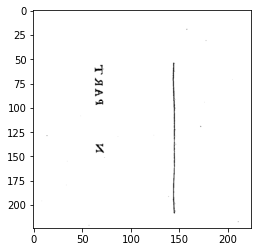

In [6]:
# 
# ========================================
# Check your data to make sure it is correct
# ========================================

# Need the __name__ check to make multiprocessing work on Windows for some reason
# if __name__ == '__main__':

for data in book_data_loaders['Defoe']['train']:
    # get the inputs
    inputs, labels = data

    # plot to verify the input is correct
    input1 = inputs[0].numpy()
    print(input1.shape)
    input1 = np.swapaxes(input1,0,2).squeeze()
    print(input1.shape)
    plt.imshow(input1,cmap='gray')

    break

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#from https://github.com/pytorch/examples/blob/master/mnist/main.py
class JQNet1(nn.Module):
    def __init__(self):
        super(JQNet1, self).__init__()
        if use_gpu:
            self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding = 1).cuda()
            self.conv2 = nn.Conv2d(10, 20, kernel_size=3, padding = 1).cuda()
            self.conv3 = nn.Conv2d(20, 40, kernel_size=3, padding = 1).cuda()
            self.conv2_drop = nn.Dropout2d(p = 0.2)
            self.conv3_drop = nn.Dropout2d(p = 0.1)

            #assumes a batch size of 50
            self.fc1 = nn.Linear(31360,64).cuda()
            self.fc2 = nn.Linear(64, 25).cuda()
            self.fc3 = nn.Linear(25,2).cuda()
        else:
            self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding = 1).cpu()
            self.conv2 = nn.Conv2d(10, 20, kernel_size=3, padding = 1).cpu()
            self.conv3 = nn.Conv2d(20, 40, kernel_size=3, padding = 1).cpu()
            self.conv2_drop = nn.Dropout2d(p = 0.2)
            self.conv3_drop = nn.Dropout2d(p = 0.1)

            #assumes a batch size of 50
            self.fc1 = nn.Linear(31360,64).cpu()
            self.fc2 = nn.Linear(64, 25).cpu()
            self.fc3 = nn.Linear(25,2).cpu()

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        
        x = x.view(x.size(0),-1) #clutch line
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        
        
        x = x.view(x.size(0),-1) #clutch line
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
        #return x

In [8]:
# ========================================
# Step 3. define model structure
#
# TODO: Stick with MNIST for now because it is smaller network and faster to train. Note that you lose
# a lot of inofmration when yo udownsample the image to 28x28. THat's okay, you optimize other parts first, e.g.,
# data loading before you optimize your model.
# ========================================
from lib.playground.utee import selector
from lib.playground.mnist import model
import os

def create_model_architecture(model_type='mnist'):
    """
    params model_type: the type of model, for now, support mnist and resnet18    
    """
    if model_type == 'mnist':
        print('using pretrained mnist model')
        
        # load the model from the playground library
        model_annotation, ds_fetcher, is_imagenet = selector.select('mnist')
        
        # remove last layer
        removed = list(model_annotation.model.children())[:-1]
        
        # add a front layer to account for new input
        # IMPORTANT, we need to update the self.input_dims of the MLP class
        removed = [nn.Linear(img_input_size*img_input_size,28*28), nn.ReLU()] + removed
        
        # formulate the layers
        model_annotation.model=torch.nn.Sequential(*removed)
        
        # add the new fc layer
        model_annotation.model.fc = torch.nn.Linear(256,2).cuda()
        
        # update the self.input_dims of the network
        model_annotation.input_dims = img_input_size * img_input_size                

    elif model_type == 'resnet18':    
        print("Transferring resnet18 and retraining with annotations dataset.")    
        model_annotation = models.resnet18(pretrained=True)
        num_params = sum(1 for i in model_annotation.parameters())

        # There are 10 layers (model_ft.children()) in resnet18
        # Freezing the first half of resnet18, freezing all params for layers 1-5
        max_layer = 5
        curr_layer = 1
        last_layer = None
        for child in model_annotation.children():
            if curr_layer <= max_layer:
                for param in child.parameters():
                    param.requires_grad = False
                last_layer = child
                curr_layer = curr_layer + 1
            else:
                break

        # Replace the final fully connected layer to perform binary classification
        num_ftrs = model_annotation.fc.in_features
        model_annotation.fc = nn.Linear(num_ftrs, 2)
        
    elif model_type == 'jq_net1':
        print("Creating JQ's net1.")
        model_annotation = JQNet1()
        

    # return
    if use_gpu:
        return model_annotation.cuda()
    else:
        return model_annotation.cpu()


In [9]:
# ========================================
# Step 4. define the training process.
#
# TODO: The basic process of train and validation is defined. Please implement the overall average validation 
# confusion matrix, meaning for each validation (after running all epochs), get the confusion matrix for that book,
# repeat this for the rest of 10 books. THen get the overall performance. Also, implement the early-stop as you
# originally has in your code. :) I removed them here for clarity. You can add them back. 
# ========================================


raw_loss = {'train': [], 'val' : []}
raw_accs = {'train': [], 'val' : []}

def train(model, criterion, optimizer, data_loaders, num_epochs=25, early_stopping = None):    
    since = time.time()
    
    # number of samples for normalization of loss
    num_samples = {p : sum([len(data_loaders[p][b].dataset) for b in data_loaders[p]]) for p in ['train', 'val']}

    # stop the training, validation, and test loop
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # looping parameters
        running_loss = 0.0
        running_corrects = 0
        confusion_matrix = tnt.meter.ConfusionMeter(2)
        
        # loop through train and val phase in each epoch
        for phase in ['train', 'val']:
            # check train or val
            if phase == 'train':                
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            # Iterate over each book
            running_loss = 0.0
            running_corrects = 0
            confusion_matrix = tnt.meter.ConfusionMeter(2)
            
            for book in tqdm_notebook(data_loaders[phase]): 
                for data in data_loaders[phase][book]:
                    # get the inputs;  wrap them in Variable and make them into gpu or not
                    inputs, labels = data # input size: [5, 1, 28, 28] ; keep the dummy color channel:1
                    if use_gpu:
                        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)
                    
                    # back
                    if phase == 'train': 
                        loss.backward()
                        optimizer.step()

                    # Add to confusion matrix
                    confusion_matrix.add(outputs.data, labels.data)

                    # statistics
#                     running_loss += loss.data[0] * inputs.size(0)
                    running_loss += loss.item()
                    running_corrects += torch.sum(preds == labels.data)
            
            # report evaluation
            print('Phase:%s' %phase)
            print('Confusion matrix:\n', confusion_matrix.conf)
            print('loss', running_loss)
            
            epoch_loss = float(running_loss) / float(num_samples[phase])
            epoch_acc = float(running_corrects) / float(num_samples[phase])
            
            raw_loss[phase].append(epoch_loss)
            raw_accs[phase].append(epoch_acc)
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    return model

In [10]:
def plot_losses(train_losses, val_losses, title, xlabel='Loss'):
    plt.plot(train_losses,label = "train")
    plt.plot(val_losses,label = "validation")
    plt.title(title)
    plt.ylabel(xlabel)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()


    print("Average Training Score: " + str(np.mean(train_losses)))
    print("Average Validation Score: " + str(np.mean(val_losses)))
#     print("Average Training Accuracy: " + str(np.mean(trainAccs)))
#     print("Average Validation Accuracy: " + str(np.mean(valAccs)))

use_gpu is True
Creating JQ's net1.
validating on book: 'Albin'
Epoch 0/499
----------



Phase:train
Confusion matrix:
 [[   2  616]
 [  18 2008]]
loss 32.51770946383476



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.29788339138031
Epoch 1/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   3 2023]]
loss 32.62112033367157



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 3.624839961528778
Epoch 2/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 31.95096045732498



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 5.6250176429748535
Epoch 3/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   2 2024]]
loss 32.59740364551544



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.157727301120758
Epoch 4/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 31.641888350248337



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 3.8525891304016113
Epoch 5/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 32.227078437805176



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 3.769191265106201
Epoch 6/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 33.05806368589401



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 3.9120184183120728
Epoch 7/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 31.869431376457214



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.039299547672272
Epoch 8/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 32.05066502094269



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.091251313686371
Epoch 9/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 31.718543231487274



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.074276030063629
Epoch 10/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 31.86553183197975



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.252345442771912
Epoch 11/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 31.37837278842926



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.384447336196899
Epoch 12/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 31.47255629301071



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.420537710189819
Epoch 13/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 31.65990737080574



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.460131645202637
Epoch 14/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 31.162522554397583



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.5607651472091675
Epoch 15/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 30.75999903678894



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.639358282089233
Epoch 16/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 31.559770554304123



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.649626135826111
Epoch 17/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 31.066971570253372



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.637949824333191
Epoch 18/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 31.188685089349747



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.706437587738037
Epoch 19/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 31.29816371202469



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.708675742149353
Epoch 20/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 31.11635050177574



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.833190202713013
Epoch 21/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 30.91291645169258



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.801247477531433
Epoch 22/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 30.751802533864975

Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.7116575837135315
Epoch 23/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 31.362996757030487



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.790494680404663
Epoch 24/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 30.997305244207382



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.806116461753845
Epoch 25/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 31.106486946344376



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.76872980594635
Epoch 26/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 30.682799458503723



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.851621031761169
Epoch 27/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 30.74379749596119



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.782685279846191
Epoch 28/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 30.98593971133232



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.798264026641846
Epoch 29/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 30.840882033109665



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.771010756492615
Epoch 30/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 31.19803959131241



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.759510278701782
Epoch 31/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 31.221479266881943



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.783841371536255
Epoch 32/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 31.306816577911377



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.686689853668213
Epoch 33/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 30.943615585565567



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.777042269706726
Epoch 34/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 31.27970263361931



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.699906587600708
Epoch 35/499
----------



Phase:train
Confusion matrix:
 [[  14  604]
 [  26 2000]]
loss 30.750721499323845



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.765279173851013
Epoch 36/499
----------



Phase:train
Confusion matrix:
 [[   2  616]
 [   1 2025]]
loss 31.239378452301025



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.781458735466003
Epoch 37/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   0 2026]]
loss 30.78176674246788



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.786324143409729
Epoch 38/499
----------



Phase:train
Confusion matrix:
 [[   2  616]
 [   0 2026]]
loss 30.84428635239601



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.706735014915466
Epoch 39/499
----------



Phase:train
Confusion matrix:
 [[   2  616]
 [   1 2025]]
loss 31.069985553622246



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.7996214628219604
Epoch 40/499
----------



Phase:train
Confusion matrix:
 [[   8  610]
 [   4 2022]]
loss 31.014366298913956



Phase:val
Confusion matrix:
 [[  1 142]
 [  0  31]]
loss 4.56845760345459
Epoch 41/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   2 2024]]
loss 31.00902134180069



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.70874297618866
Epoch 42/499
----------



Phase:train
Confusion matrix:
 [[   1  617]
 [   1 2025]]
loss 30.902885019779205



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 8.589379072189331
Epoch 43/499
----------



Phase:train
Confusion matrix:
 [[   2  616]
 [   5 2021]]
loss 31.742070108652115



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.563646197319031
Epoch 44/499
----------



Phase:train
Confusion matrix:
 [[   0  618]
 [   1 2025]]
loss 30.991394013166428



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.582600712776184
Epoch 45/499
----------



Phase:train
Confusion matrix:
 [[  20  598]
 [  19 2007]]
loss 30.412591844797134



Phase:val
Confusion matrix:
 [[ 14 129]
 [  0  31]]
loss 4.41997754573822
Epoch 46/499
----------



Phase:train
Confusion matrix:
 [[  59  559]
 [  23 2003]]
loss 30.41960772871971



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 4.733344316482544
Epoch 47/499
----------



Phase:train
Confusion matrix:
 [[  23  595]
 [   7 2019]]
loss 30.393462002277374



Phase:val
Confusion matrix:
 [[ 23 120]
 [  3  28]]
loss 4.267016708850861
Epoch 48/499
----------



Phase:train
Confusion matrix:
 [[  58  560]
 [  35 1991]]
loss 29.993013709783554



Phase:val
Confusion matrix:
 [[ 11 132]
 [  1  30]]
loss 4.842661142349243
Epoch 49/499
----------



Phase:train
Confusion matrix:
 [[  36  582]
 [  13 2013]]
loss 30.350575625896454



Phase:val
Confusion matrix:
 [[  4 139]
 [  0  31]]
loss 4.555057764053345
Epoch 50/499
----------



Phase:train
Confusion matrix:
 [[  41  577]
 [  12 2014]]
loss 30.04994633793831



Phase:val
Confusion matrix:
 [[ 22 121]
 [  3  28]]
loss 4.389047265052795
Epoch 51/499
----------



Phase:train
Confusion matrix:
 [[  72  546]
 [  19 2007]]
loss 29.975789666175842



Phase:val
Confusion matrix:
 [[ 25 118]
 [  4  27]]
loss 4.183282554149628
Epoch 52/499
----------



Phase:train
Confusion matrix:
 [[  59  559]
 [  15 2011]]
loss 29.594684541225433



Phase:val
Confusion matrix:
 [[ 24 119]
 [  4  27]]
loss 4.3415563106536865
Epoch 53/499
----------



Phase:train
Confusion matrix:
 [[  55  563]
 [  21 2005]]
loss 30.146302551031113



Phase:val
Confusion matrix:
 [[ 24 119]
 [  3  28]]
loss 4.337909400463104
Epoch 54/499
----------



Phase:train
Confusion matrix:
 [[  67  551]
 [  16 2010]]
loss 29.45172679424286



Phase:val
Confusion matrix:
 [[  1 142]
 [  0  31]]
loss 5.1134432554244995
Epoch 55/499
----------



Phase:train
Confusion matrix:
 [[  38  580]
 [  12 2014]]
loss 30.59100192785263



Phase:val
Confusion matrix:
 [[ 21 122]
 [  2  29]]
loss 4.4035380482673645
Epoch 56/499
----------



Phase:train
Confusion matrix:
 [[  67  551]
 [  11 2015]]
loss 29.56706315279007



Phase:val
Confusion matrix:
 [[ 23 120]
 [  3  28]]
loss 4.441755533218384
Epoch 57/499
----------



Phase:train
Confusion matrix:
 [[  69  549]
 [  18 2008]]
loss 29.62533649802208



Phase:val
Confusion matrix:
 [[  2 141]
 [  0  31]]
loss 4.860416412353516
Epoch 58/499
----------



Phase:train
Confusion matrix:
 [[  82  536]
 [  11 2015]]
loss 29.420229703187943



Phase:val
Confusion matrix:
 [[ 24 119]
 [  3  28]]
loss 4.424949884414673
Epoch 59/499
----------



Phase:train
Confusion matrix:
 [[  80  538]
 [  22 2004]]
loss 29.451003462076187



Phase:val
Confusion matrix:
 [[ 22 121]
 [  3  28]]
loss 4.470181465148926
Epoch 60/499
----------



Phase:train
Confusion matrix:
 [[  70  548]
 [  13 2013]]
loss 28.827599599957466



Phase:val
Confusion matrix:
 [[ 17 126]
 [  2  29]]
loss 4.605489730834961
Epoch 61/499
----------



Phase:train
Confusion matrix:
 [[  90  528]
 [  14 2012]]
loss 28.80722451210022



Phase:val
Confusion matrix:
 [[ 22 121]
 [  3  28]]
loss 4.50061821937561
Epoch 62/499
----------



Phase:train
Confusion matrix:
 [[  88  530]
 [  13 2013]]
loss 28.57452255487442



Phase:val
Confusion matrix:
 [[ 21 122]
 [  3  28]]
loss 4.499616801738739
Epoch 63/499
----------



Phase:train
Confusion matrix:
 [[  92  526]
 [  17 2009]]
loss 28.902340531349182



Phase:val
Confusion matrix:
 [[ 10 133]
 [  2  29]]
loss 4.860668182373047
Epoch 64/499
----------



Phase:train
Confusion matrix:
 [[  80  538]
 [  12 2014]]
loss 28.952304899692535



Phase:val
Confusion matrix:
 [[ 18 125]
 [  2  29]]
loss 4.689144253730774
Epoch 65/499
----------



Phase:train
Confusion matrix:
 [[  91  527]
 [  14 2012]]
loss 28.7850072234869



Phase:val
Confusion matrix:
 [[ 20 123]
 [  2  29]]
loss 4.705833315849304
Epoch 66/499
----------



Phase:train
Confusion matrix:
 [[  85  533]
 [  17 2009]]
loss 28.67693340778351



Phase:val
Confusion matrix:
 [[ 20 123]
 [  3  28]]
loss 4.6652820110321045
Epoch 67/499
----------



Phase:train
Confusion matrix:
 [[  85  533]
 [  25 2001]]
loss 29.514557152986526



Phase:val
Confusion matrix:
 [[ 20 123]
 [  2  29]]
loss 4.77513575553894
Epoch 68/499
----------



Phase:train
Confusion matrix:
 [[  82  536]
 [  14 2012]]
loss 28.8956408649683



Phase:val
Confusion matrix:
 [[ 18 125]
 [  2  29]]
loss 4.747453808784485
Epoch 69/499
----------



Phase:train
Confusion matrix:
 [[  88  530]
 [  13 2013]]
loss 28.692060351371765



Phase:val
Confusion matrix:
 [[ 20 123]
 [  2  29]]
loss 4.6618993282318115
Epoch 70/499
----------



Phase:train
Confusion matrix:
 [[  88  530]
 [  15 2011]]
loss 28.99407882988453



Phase:val
Confusion matrix:
 [[ 22 121]
 [  2  29]]
loss 4.650130033493042
Epoch 71/499
----------



Phase:train
Confusion matrix:
 [[  92  526]
 [  13 2013]]
loss 28.343587890267372



Phase:val
Confusion matrix:
 [[ 15 128]
 [  2  29]]
loss 4.772325038909912
Epoch 72/499
----------



Phase:train
Confusion matrix:
 [[  83  535]
 [  19 2007]]
loss 29.174848288297653



Phase:val
Confusion matrix:
 [[ 22 121]
 [  3  28]]
loss 4.631212115287781
Epoch 73/499
----------



Phase:train
Confusion matrix:
 [[  82  536]
 [  15 2011]]
loss 28.91445527970791



Phase:val
Confusion matrix:
 [[ 16 127]
 [  3  28]]
loss 4.797685742378235
Epoch 74/499
----------



Phase:train
Confusion matrix:
 [[  90  528]
 [  19 2007]]
loss 29.807547122240067



Phase:val
Confusion matrix:
 [[ 13 130]
 [  1  30]]
loss 4.863277912139893
Epoch 75/499
----------



Phase:train
Confusion matrix:
 [[  78  540]
 [  17 2009]]
loss 28.696021169424057



Phase:val
Confusion matrix:
 [[ 23 120]
 [  3  28]]
loss 4.687473297119141
Epoch 76/499
----------



Phase:train
Confusion matrix:
 [[  98  520]
 [  15 2011]]
loss 29.12053817510605



Phase:val
Confusion matrix:
 [[ 22 121]
 [  3  28]]
loss 4.630260229110718
Epoch 77/499
----------



Phase:train
Confusion matrix:
 [[  80  538]
 [  13 2013]]
loss 29.18100281059742



Phase:val
Confusion matrix:
 [[ 24 119]
 [  3  28]]
loss 4.584952473640442
Epoch 78/499
----------



Phase:train
Confusion matrix:
 [[  98  520]
 [  18 2008]]
loss 28.95828987658024



Phase:val
Confusion matrix:
 [[ 24 119]
 [  3  28]]
loss 4.478447258472443
Epoch 79/499
----------



Phase:train
Confusion matrix:
 [[  92  526]
 [  18 2008]]
loss 28.960789397358894



Phase:val
Confusion matrix:
 [[ 10 133]
 [  0  31]]
loss 4.77305006980896
Epoch 80/499
----------



Phase:train
Confusion matrix:
 [[  67  551]
 [  13 2013]]
loss 29.529113292694092



Phase:val
Confusion matrix:
 [[ 24 119]
 [  3  28]]
loss 4.484548211097717
Epoch 81/499
----------



Phase:train
Confusion matrix:
 [[  90  528]
 [  14 2012]]
loss 28.761822924017906



Phase:val
Confusion matrix:
 [[  9 134]
 [  0  31]]
loss 4.729938387870789
Epoch 82/499
----------



Phase:train
Confusion matrix:
 [[  75  543]
 [  13 2013]]
loss 29.339784860610962



Phase:val
Confusion matrix:
 [[ 24 119]
 [  3  28]]
loss 4.59536337852478
Epoch 83/499
----------



Phase:train
Confusion matrix:
 [[  89  529]
 [  16 2010]]
loss 28.990981847047806



Phase:val
Confusion matrix:
 [[ 22 121]
 [  3  28]]
loss 4.742289781570435
Epoch 84/499
----------



Phase:train
Confusion matrix:
 [[  91  527]
 [  16 2010]]
loss 28.58008261024952



Phase:val
Confusion matrix:
 [[ 23 120]
 [  3  28]]
loss 4.62662947177887
Epoch 85/499
----------



Phase:train
Confusion matrix:
 [[  96  522]
 [  16 2010]]
loss 28.524836629629135



Phase:val
Confusion matrix:
 [[ 23 120]
 [  3  28]]
loss 4.598222732543945
Epoch 86/499
----------



Phase:train
Confusion matrix:
 [[  95  523]
 [  18 2008]]
loss 29.22156384587288



Phase:val
Confusion matrix:
 [[ 20 123]
 [  2  29]]
loss 4.682766079902649
Epoch 87/499
----------



Phase:train
Confusion matrix:
 [[  96  522]
 [  18 2008]]
loss 29.282792419195175



Phase:val
Confusion matrix:
 [[ 18 125]
 [  2  29]]
loss 4.862820982933044
Epoch 88/499
----------



Phase:train
Confusion matrix:
 [[  92  526]
 [  16 2010]]
loss 28.44675861299038



Phase:val
Confusion matrix:
 [[ 22 121]
 [  2  29]]
loss 4.583225607872009
Epoch 89/499
----------



Phase:train
Confusion matrix:
 [[  99  519]
 [  14 2012]]
loss 28.590540423989296



Phase:val
Confusion matrix:
 [[ 22 121]
 [  2  29]]
loss 4.5952242612838745
Epoch 90/499
----------



Phase:train
Confusion matrix:
 [[ 100  518]
 [  16 2010]]
loss 28.865189895033836



Phase:val
Confusion matrix:
 [[ 21 122]
 [  2  29]]
loss 4.546462774276733
Epoch 91/499
----------



Phase:train
Confusion matrix:
 [[  84  534]
 [  20 2006]]
loss 29.050059407949448



Phase:val
Confusion matrix:
 [[ 21 122]
 [  2  29]]
loss 4.840254426002502
Epoch 92/499
----------



Phase:train
Confusion matrix:
 [[  89  529]
 [  15 2011]]
loss 28.792297273874283



Phase:val
Confusion matrix:
 [[ 21 122]
 [  2  29]]
loss 4.613683700561523
Epoch 93/499
----------



Phase:train
Confusion matrix:
 [[  95  523]
 [  19 2007]]
loss 28.24229209125042



Phase:val
Confusion matrix:
 [[ 10 133]
 [  1  30]]
loss 4.948678970336914
Epoch 94/499
----------



Phase:train
Confusion matrix:
 [[  94  524]
 [  19 2007]]
loss 28.929617404937744



Phase:val
Confusion matrix:
 [[ 21 122]
 [  2  29]]
loss 4.513223588466644
Epoch 95/499
----------



Phase:train
Confusion matrix:
 [[  93  525]
 [  14 2012]]
loss 28.83700929582119



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.550702214241028
Epoch 96/499
----------



Phase:train
Confusion matrix:
 [[  99  519]
 [  16 2010]]
loss 28.993325859308243



Phase:val
Confusion matrix:
 [[ 21 122]
 [  2  29]]
loss 4.635406255722046
Epoch 97/499
----------



Phase:train
Confusion matrix:
 [[ 100  518]
 [  15 2011]]
loss 28.81893962621689



Phase:val
Confusion matrix:
 [[ 20 123]
 [  2  29]]
loss 4.656400918960571
Epoch 98/499
----------



Phase:train
Confusion matrix:
 [[  92  526]
 [  13 2013]]
loss 29.00105282664299



Phase:val
Confusion matrix:
 [[ 22 121]
 [  2  29]]
loss 4.5862098932266235
Epoch 99/499
----------



Phase:train
Confusion matrix:
 [[ 109  509]
 [  12 2014]]
loss 28.49302263557911



Phase:val
Confusion matrix:
 [[ 21 122]
 [  2  29]]
loss 4.493070423603058
Epoch 100/499
----------



Phase:train
Confusion matrix:
 [[  88  530]
 [  15 2011]]
loss 29.36321796476841



Phase:val
Confusion matrix:
 [[ 19 124]
 [  2  29]]
loss 4.669699549674988
Epoch 101/499
----------



Phase:train
Confusion matrix:
 [[  96  522]
 [  17 2009]]
loss 28.862869650125504



Phase:val
Confusion matrix:
 [[ 21 122]
 [  2  29]]
loss 4.656132340431213
Epoch 102/499
----------



Phase:train
Confusion matrix:
 [[  95  523]
 [  17 2009]]
loss 28.276417165994644



Phase:val
Confusion matrix:
 [[ 22 121]
 [  2  29]]
loss 4.686039566993713
Epoch 103/499
----------



Phase:train
Confusion matrix:
 [[ 105  513]
 [  15 2011]]
loss 28.739930003881454



Phase:val
Confusion matrix:
 [[ 22 121]
 [  2  29]]
loss 4.602571368217468
Epoch 104/499
----------



Phase:train
Confusion matrix:
 [[  97  521]
 [  17 2009]]
loss 28.517609655857086



Phase:val
Confusion matrix:
 [[ 23 120]
 [  4  27]]
loss 4.4678884744644165
Epoch 105/499
----------



Phase:train
Confusion matrix:
 [[ 111  507]
 [  24 2002]]
loss 28.93995277583599



Phase:val
Confusion matrix:
 [[47 96]
 [ 5 26]]
loss 4.067234814167023
Epoch 106/499
----------



Phase:train
Confusion matrix:
 [[  89  529]
 [  15 2011]]
loss 29.189814805984497



Phase:val
Confusion matrix:
 [[  0 143]
 [  0  31]]
loss 5.2349478006362915
Epoch 107/499
----------



Phase:train
Confusion matrix:
 [[  25  593]
 [  12 2014]]
loss 30.385335236787796



Phase:val
Confusion matrix:
 [[ 17 126]
 [  2  29]]
loss 4.738228440284729
Epoch 108/499
----------



Phase:train
Confusion matrix:
 [[ 100  518]
 [  21 2005]]
loss 28.78018468618393



Phase:val
Confusion matrix:
 [[ 22 121]
 [  2  29]]
loss 4.754133641719818
Epoch 109/499
----------



Phase:train
Confusion matrix:
 [[  92  526]
 [  14 2012]]
loss 29.350925713777542



Phase:val
Confusion matrix:
 [[ 20 123]
 [  2  29]]
loss 4.655553102493286
Epoch 110/499
----------



Phase:train
Confusion matrix:
 [[  97  521]
 [  14 2012]]
loss 28.824535325169563



Phase:val
Confusion matrix:
 [[ 22 121]
 [  2  29]]
loss 4.605148673057556
Epoch 111/499
----------



Phase:train
Confusion matrix:
 [[ 104  514]
 [  17 2009]]
loss 28.787527829408646



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.585220456123352
Epoch 112/499
----------



Phase:train
Confusion matrix:
 [[ 102  516]
 [  13 2013]]
loss 28.668060213327408



Phase:val
Confusion matrix:
 [[ 22 121]
 [  2  29]]
loss 4.615931987762451
Epoch 113/499
----------



Phase:train
Confusion matrix:
 [[  94  524]
 [  21 2005]]
loss 28.90163792669773



Phase:val
Confusion matrix:
 [[ 20 123]
 [  1  30]]
loss 4.7110912799835205
Epoch 114/499
----------



Phase:train
Confusion matrix:
 [[  96  522]
 [  16 2010]]
loss 28.969721108675003



Phase:val
Confusion matrix:
 [[ 22 121]
 [  2  29]]
loss 4.542614758014679
Epoch 115/499
----------



Phase:train
Confusion matrix:
 [[ 102  516]
 [  20 2006]]
loss 28.77359938621521



Phase:val
Confusion matrix:
 [[ 25 118]
 [  3  28]]
loss 4.296347618103027
Epoch 116/499
----------



Phase:train
Confusion matrix:
 [[  92  526]
 [  24 2002]]
loss 29.24777816236019



Phase:val
Confusion matrix:
 [[ 18 125]
 [  1  30]]
loss 4.7312023639678955
Epoch 117/499
----------



Phase:train
Confusion matrix:
 [[  99  519]
 [  11 2015]]
loss 29.868729010224342



Phase:val
Confusion matrix:
 [[ 22 121]
 [  2  29]]
loss 4.568358063697815
Epoch 118/499
----------



Phase:train
Confusion matrix:
 [[  82  536]
 [  18 2008]]
loss 28.733130514621735



Phase:val
Confusion matrix:
 [[ 22 121]
 [  2  29]]
loss 4.7014700174331665
Epoch 119/499
----------



Phase:train
Confusion matrix:
 [[  98  520]
 [  17 2009]]
loss 28.872275799512863



Phase:val
Confusion matrix:
 [[ 22 121]
 [  2  29]]
loss 4.475714683532715
Epoch 120/499
----------



Phase:train
Confusion matrix:
 [[ 102  516]
 [  19 2007]]
loss 28.771260306239128



Phase:val
Confusion matrix:
 [[  8 135]
 [  0  31]]
loss 4.953711748123169
Epoch 121/499
----------



Phase:train
Confusion matrix:
 [[  93  525]
 [  16 2010]]
loss 28.511480435729027



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.513116478919983
Epoch 122/499
----------



Phase:train
Confusion matrix:
 [[ 101  517]
 [  16 2010]]
loss 28.665348559617996



Phase:val
Confusion matrix:
 [[ 22 121]
 [  2  29]]
loss 4.5787107944488525
Epoch 123/499
----------



Phase:train
Confusion matrix:
 [[ 104  514]
 [  18 2008]]
loss 28.138118654489517



Phase:val
Confusion matrix:
 [[ 21 122]
 [  2  29]]
loss 4.551060378551483
Epoch 124/499
----------



Phase:train
Confusion matrix:
 [[  81  537]
 [  11 2015]]
loss 28.999498590826988



Phase:val
Confusion matrix:
 [[ 22 121]
 [  2  29]]
loss 4.624027967453003
Epoch 125/499
----------



Phase:train
Confusion matrix:
 [[ 105  513]
 [  16 2010]]
loss 28.74266542494297



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.652263879776001
Epoch 126/499
----------



Phase:train
Confusion matrix:
 [[  91  527]
 [  19 2007]]
loss 29.113630697131157



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.701316654682159
Epoch 127/499
----------



Phase:train
Confusion matrix:
 [[  96  522]
 [  19 2007]]
loss 28.889641135931015



Phase:val
Confusion matrix:
 [[ 22 121]
 [  2  29]]
loss 4.536002159118652
Epoch 128/499
----------



Phase:train
Confusion matrix:
 [[ 104  514]
 [  16 2010]]
loss 28.328935891389847



Phase:val
Confusion matrix:
 [[ 20 123]
 [  1  30]]
loss 4.620706140995026
Epoch 129/499
----------



Phase:train
Confusion matrix:
 [[  99  519]
 [  13 2013]]
loss 28.59206248819828



Phase:val
Confusion matrix:
 [[ 20 123]
 [  2  29]]
loss 4.7550270557403564
Epoch 130/499
----------



Phase:train
Confusion matrix:
 [[ 103  515]
 [  12 2014]]
loss 29.012874975800514



Phase:val
Confusion matrix:
 [[ 21 122]
 [  2  29]]
loss 4.612866759300232
Epoch 131/499
----------



Phase:train
Confusion matrix:
 [[  99  519]
 [  16 2010]]
loss 29.08220049738884



Phase:val
Confusion matrix:
 [[ 22 121]
 [  2  29]]
loss 4.5266740918159485
Epoch 132/499
----------



Phase:train
Confusion matrix:
 [[ 100  518]
 [  14 2012]]
loss 28.79756173491478



Phase:val
Confusion matrix:
 [[ 20 123]
 [  1  30]]
loss 4.739580869674683
Epoch 133/499
----------



Phase:train
Confusion matrix:
 [[  83  535]
 [  15 2011]]
loss 28.748482406139374



Phase:val
Confusion matrix:
 [[ 22 121]
 [  2  29]]
loss 4.504774510860443
Epoch 134/499
----------



Phase:train
Confusion matrix:
 [[  97  521]
 [  16 2010]]
loss 28.487668871879578



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.5145920515060425
Epoch 135/499
----------



Phase:train
Confusion matrix:
 [[  99  519]
 [  17 2009]]
loss 28.793114721775055



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.56609308719635
Epoch 136/499
----------



Phase:train
Confusion matrix:
 [[ 103  515]
 [  18 2008]]
loss 28.566852062940598



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.517884790897369
Epoch 137/499
----------



Phase:train
Confusion matrix:
 [[  89  529]
 [  17 2009]]
loss 29.39597925543785



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.446701645851135
Epoch 138/499
----------



Phase:train
Confusion matrix:
 [[  99  519]
 [  20 2006]]
loss 28.819374591112137



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.522774040699005
Epoch 139/499
----------



Phase:train
Confusion matrix:
 [[ 100  518]
 [  21 2005]]
loss 28.6564412266016



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.5510207414627075
Epoch 140/499
----------



Phase:train
Confusion matrix:
 [[ 105  513]
 [  18 2008]]
loss 28.69142436981201



Phase:val
Confusion matrix:
 [[ 22 121]
 [  1  30]]
loss 4.6881349086761475
Epoch 141/499
----------



Phase:train
Confusion matrix:
 [[  98  520]
 [  14 2012]]
loss 28.439408004283905



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.52685284614563
Epoch 142/499
----------



Phase:train
Confusion matrix:
 [[ 107  511]
 [  18 2008]]
loss 28.143482968211174



Phase:val
Confusion matrix:
 [[ 22 121]
 [  2  29]]
loss 4.584768533706665
Epoch 143/499
----------



Phase:train
Confusion matrix:
 [[  93  525]
 [  17 2009]]
loss 28.96901349723339



Phase:val
Confusion matrix:
 [[ 21 122]
 [  2  29]]
loss 4.6962316036224365
Epoch 144/499
----------



Phase:train
Confusion matrix:
 [[  92  526]
 [  15 2011]]
loss 28.35119330883026



Phase:val
Confusion matrix:
 [[ 20 123]
 [  2  29]]
loss 4.7482830286026
Epoch 145/499
----------



Phase:train
Confusion matrix:
 [[  97  521]
 [  17 2009]]
loss 28.731367230415344



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.658727407455444
Epoch 146/499
----------



Phase:train
Confusion matrix:
 [[ 101  517]
 [  14 2012]]
loss 28.611461281776428



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.672679901123047
Epoch 147/499
----------



Phase:train
Confusion matrix:
 [[ 101  517]
 [  16 2010]]
loss 28.46709294617176



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.560517311096191
Epoch 148/499
----------



Phase:train
Confusion matrix:
 [[ 108  510]
 [  23 2003]]
loss 29.10759337246418



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.68401825428009
Epoch 149/499
----------



Phase:train
Confusion matrix:
 [[ 102  516]
 [  17 2009]]
loss 28.502689957618713



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.591124415397644
Epoch 150/499
----------



Phase:train
Confusion matrix:
 [[ 104  514]
 [  19 2007]]
loss 28.51343995332718



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.470113694667816
Epoch 151/499
----------



Phase:train
Confusion matrix:
 [[  96  522]
 [  17 2009]]
loss 28.61621168255806



Phase:val
Confusion matrix:
 [[ 22 121]
 [  2  29]]
loss 4.491048872470856
Epoch 152/499
----------



Phase:train
Confusion matrix:
 [[ 110  508]
 [  15 2011]]
loss 28.3214929997921



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.673163414001465
Epoch 153/499
----------



Phase:train
Confusion matrix:
 [[ 101  517]
 [  19 2007]]
loss 28.64475592970848



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.637741804122925
Epoch 154/499
----------



Phase:train
Confusion matrix:
 [[  99  519]
 [  12 2014]]
loss 28.728267192840576



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.639329493045807
Epoch 155/499
----------



Phase:train
Confusion matrix:
 [[ 110  508]
 [  19 2007]]
loss 28.30248036980629



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.608025670051575
Epoch 156/499
----------



Phase:train
Confusion matrix:
 [[ 106  512]
 [  17 2009]]
loss 28.122309610247612



Phase:val
Confusion matrix:
 [[ 24 119]
 [  2  29]]
loss 4.632540822029114
Epoch 157/499
----------



Phase:train
Confusion matrix:
 [[  99  519]
 [  16 2010]]
loss 28.80493587255478



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.627055048942566
Epoch 158/499
----------



Phase:train
Confusion matrix:
 [[ 103  515]
 [   9 2017]]
loss 28.1823947429657



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.658698320388794
Epoch 159/499
----------



Phase:train
Confusion matrix:
 [[ 103  515]
 [  21 2005]]
loss 28.808961883187294



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.6556395292282104
Epoch 160/499
----------



Phase:train
Confusion matrix:
 [[ 100  518]
 [  16 2010]]
loss 28.986977443099022



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.4484938979148865
Epoch 161/499
----------



Phase:train
Confusion matrix:
 [[  98  520]
 [  15 2011]]
loss 28.738448709249496



Phase:val
Confusion matrix:
 [[ 20 123]
 [  1  30]]
loss 4.680320739746094
Epoch 162/499
----------



Phase:train
Confusion matrix:
 [[ 108  510]
 [  14 2012]]
loss 27.788830295205116



Phase:val
Confusion matrix:
 [[ 21 122]
 [  1  30]]
loss 4.523935437202454
Epoch 163/499
----------



Phase:train
Confusion matrix:
 [[  95  523]
 [  20 2006]]
loss 28.67253939807415



Phase:val
Confusion matrix:
 [[ 25 118]
 [  2  29]]
loss 4.5273977518081665
Epoch 164/499
----------



Phase:train
Confusion matrix:
 [[  95  523]
 [  19 2007]]
loss 28.24807943403721



Phase:val
Confusion matrix:
 [[ 24 119]
 [  2  29]]
loss 4.667954921722412
Epoch 165/499
----------



Phase:train
Confusion matrix:
 [[  97  521]
 [  16 2010]]
loss 28.580360293388367



Phase:val
Confusion matrix:
 [[ 25 118]
 [  2  29]]
loss 4.612859010696411
Epoch 166/499
----------



Phase:train
Confusion matrix:
 [[  90  528]
 [  16 2010]]
loss 28.657935559749603



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.568986177444458
Epoch 167/499
----------



Phase:train
Confusion matrix:
 [[  97  521]
 [  16 2010]]
loss 28.885346934199333



Phase:val
Confusion matrix:
 [[ 21 122]
 [  2  29]]
loss 4.508922815322876
Epoch 168/499
----------



Phase:train
Confusion matrix:
 [[  95  523]
 [  17 2009]]
loss 28.948317006230354



Phase:val
Confusion matrix:
 [[ 26 117]
 [  2  29]]
loss 4.450216293334961
Epoch 169/499
----------



Phase:train
Confusion matrix:
 [[ 106  512]
 [  24 2002]]
loss 28.525045052170753



Phase:val
Confusion matrix:
 [[ 25 118]
 [  3  28]]
loss 4.229767680168152
Epoch 170/499
----------



Phase:train
Confusion matrix:
 [[  99  519]
 [  17 2009]]
loss 28.832533717155457



Phase:val
Confusion matrix:
 [[ 21 122]
 [  1  30]]
loss 4.51362681388855
Epoch 171/499
----------



Phase:train
Confusion matrix:
 [[  89  529]
 [  12 2014]]
loss 28.816287502646446



Phase:val
Confusion matrix:
 [[ 22 121]
 [  2  29]]
loss 4.569671273231506
Epoch 172/499
----------



Phase:train
Confusion matrix:
 [[ 104  514]
 [  19 2007]]
loss 28.599269852042198



Phase:val
Confusion matrix:
 [[ 22 121]
 [  2  29]]
loss 4.509835720062256
Epoch 173/499
----------



Phase:train
Confusion matrix:
 [[ 101  517]
 [  14 2012]]
loss 28.630052655935287



Phase:val
Confusion matrix:
 [[ 24 119]
 [  2  29]]
loss 4.622061610221863
Epoch 174/499
----------



Phase:train
Confusion matrix:
 [[ 103  515]
 [  14 2012]]
loss 28.80127404630184



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.462088584899902
Epoch 175/499
----------



Phase:train
Confusion matrix:
 [[ 113  505]
 [  23 2003]]
loss 28.041110709309578



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.429457008838654
Epoch 176/499
----------



Phase:train
Confusion matrix:
 [[ 102  516]
 [  19 2007]]
loss 28.48970028758049



Phase:val
Confusion matrix:
 [[ 22 121]
 [  2  29]]
loss 4.606505751609802
Epoch 177/499
----------



Phase:train
Confusion matrix:
 [[  88  530]
 [  15 2011]]
loss 28.72466190159321



Phase:val
Confusion matrix:
 [[ 22 121]
 [  1  30]]
loss 4.546952843666077
Epoch 178/499
----------



Phase:train
Confusion matrix:
 [[ 110  508]
 [  25 2001]]
loss 28.243424847722054



Phase:val
Confusion matrix:
 [[ 26 117]
 [  3  28]]
loss 4.364701688289642
Epoch 179/499
----------



Phase:train
Confusion matrix:
 [[  98  520]
 [  15 2011]]
loss 28.80029335618019



Phase:val
Confusion matrix:
 [[ 22 121]
 [  1  30]]
loss 4.552323698997498
Epoch 180/499
----------



Phase:train
Confusion matrix:
 [[ 100  518]
 [  18 2008]]
loss 28.591210082173347



Phase:val
Confusion matrix:
 [[ 26 117]
 [  3  28]]
loss 4.466963112354279
Epoch 181/499
----------



Phase:train
Confusion matrix:
 [[ 104  514]
 [  20 2006]]
loss 28.693752810359



Phase:val
Confusion matrix:
 [[ 27 116]
 [  3  28]]
loss 4.3493043184280396
Epoch 182/499
----------



Phase:train
Confusion matrix:
 [[ 101  517]
 [  19 2007]]
loss 28.470109164714813



Phase:val
Confusion matrix:
 [[ 29 114]
 [  3  28]]
loss 4.192244172096252
Epoch 183/499
----------



Phase:train
Confusion matrix:
 [[ 105  513]
 [  13 2013]]
loss 28.38798888027668



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.240226864814758
Epoch 184/499
----------



Phase:train
Confusion matrix:
 [[  99  519]
 [  17 2009]]
loss 29.04518100619316



Phase:val
Confusion matrix:
 [[ 41 102]
 [  3  28]]
loss 4.265391409397125
Epoch 185/499
----------



Phase:train
Confusion matrix:
 [[ 112  506]
 [  23 2003]]
loss 28.863384649157524



Phase:val
Confusion matrix:
 [[ 30 113]
 [  3  28]]
loss 4.232418119907379
Epoch 186/499
----------



Phase:train
Confusion matrix:
 [[ 111  507]
 [  17 2009]]
loss 28.453247621655464



Phase:val
Confusion matrix:
 [[ 41 102]
 [  3  28]]
loss 4.051571011543274
Epoch 187/499
----------



Phase:train
Confusion matrix:
 [[ 111  507]
 [  21 2005]]
loss 28.2868754863739



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.187545418739319
Epoch 188/499
----------



Phase:train
Confusion matrix:
 [[ 103  515]
 [  16 2010]]
loss 29.13228866457939



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.658108234405518
Epoch 189/499
----------



Phase:train
Confusion matrix:
 [[  97  521]
 [  16 2010]]
loss 28.439176127314568



Phase:val
Confusion matrix:
 [[ 21 122]
 [  2  29]]
loss 4.665528774261475
Epoch 190/499
----------



Phase:train
Confusion matrix:
 [[ 100  518]
 [  12 2014]]
loss 28.62684240937233



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.599035263061523
Epoch 191/499
----------



Phase:train
Confusion matrix:
 [[ 108  510]
 [  21 2005]]
loss 28.50827768445015



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.5332725048065186
Epoch 192/499
----------



Phase:train
Confusion matrix:
 [[  96  522]
 [  19 2007]]
loss 29.528825029730797



Phase:val
Confusion matrix:
 [[ 18 125]
 [  1  30]]
loss 4.513006031513214
Epoch 193/499
----------



Phase:train
Confusion matrix:
 [[  89  529]
 [  13 2013]]
loss 29.227230206131935



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.426515221595764
Epoch 194/499
----------



Phase:train
Confusion matrix:
 [[  98  520]
 [  23 2003]]
loss 29.08963081240654



Phase:val
Confusion matrix:
 [[ 24 119]
 [  2  29]]
loss 4.43001925945282
Epoch 195/499
----------



Phase:train
Confusion matrix:
 [[ 100  518]
 [  19 2007]]
loss 28.64883814752102



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.666766166687012
Epoch 196/499
----------



Phase:train
Confusion matrix:
 [[  92  526]
 [  21 2005]]
loss 28.802137479186058



Phase:val
Confusion matrix:
 [[ 18 125]
 [  1  30]]
loss 4.70274031162262
Epoch 197/499
----------



Phase:train
Confusion matrix:
 [[ 105  513]
 [  20 2006]]
loss 28.251078322529793



Phase:val
Confusion matrix:
 [[  7 136]
 [  1  30]]
loss 4.8626744747161865
Epoch 198/499
----------



Phase:train
Confusion matrix:
 [[ 108  510]
 [  18 2008]]
loss 28.421739384531975



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.446873903274536
Epoch 199/499
----------



Phase:train
Confusion matrix:
 [[  95  523]
 [  21 2005]]
loss 29.39534540474415



Phase:val
Confusion matrix:
 [[ 22 121]
 [  2  29]]
loss 4.4217944741249084
Epoch 200/499
----------



Phase:train
Confusion matrix:
 [[ 102  516]
 [  18 2008]]
loss 28.195050597190857



Phase:val
Confusion matrix:
 [[ 22 121]
 [  2  29]]
loss 4.6325342655181885
Epoch 201/499
----------



Phase:train
Confusion matrix:
 [[ 103  515]
 [  17 2009]]
loss 28.76542229950428



Phase:val
Confusion matrix:
 [[ 24 119]
 [  2  29]]
loss 4.2500128746032715
Epoch 202/499
----------



Phase:train
Confusion matrix:
 [[ 103  515]
 [  28 1998]]
loss 28.487219855189323



Phase:val
Confusion matrix:
 [[ 20 123]
 [  1  30]]
loss 4.66123902797699
Epoch 203/499
----------



Phase:train
Confusion matrix:
 [[ 105  513]
 [  24 2002]]
loss 28.744304448366165



Phase:val
Confusion matrix:
 [[ 34 109]
 [  3  28]]
loss 4.275551855564117
Epoch 204/499
----------



Phase:train
Confusion matrix:
 [[ 105  513]
 [  22 2004]]
loss 28.207274824380875



Phase:val
Confusion matrix:
 [[ 42 101]
 [  4  27]]
loss 4.035528540611267
Epoch 205/499
----------



Phase:train
Confusion matrix:
 [[ 110  508]
 [  22 2004]]
loss 28.302238807082176



Phase:val
Confusion matrix:
 [[ 41 102]
 [  3  28]]
loss 4.062880456447601
Epoch 206/499
----------



Phase:train
Confusion matrix:
 [[ 110  508]
 [  24 2002]]
loss 28.43553563952446



Phase:val
Confusion matrix:
 [[ 35 108]
 [  3  28]]
loss 4.312744081020355
Epoch 207/499
----------



Phase:train
Confusion matrix:
 [[ 111  507]
 [  17 2009]]
loss 28.074924021959305



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.025325834751129
Epoch 208/499
----------



Phase:train
Confusion matrix:
 [[ 117  501]
 [  21 2005]]
loss 27.67785382270813



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.292983114719391
Epoch 209/499
----------



Phase:train
Confusion matrix:
 [[ 113  505]
 [  19 2007]]
loss 27.74424257874489



Phase:val
Confusion matrix:
 [[ 38 105]
 [  3  28]]
loss 4.165342688560486
Epoch 210/499
----------



Phase:train
Confusion matrix:
 [[ 110  508]
 [  20 2006]]
loss 28.07356107234955



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.059882044792175
Epoch 211/499
----------



Phase:train
Confusion matrix:
 [[ 109  509]
 [  21 2005]]
loss 29.421017333865166



Phase:val
Confusion matrix:
 [[ 21 122]
 [  1  30]]
loss 4.356809496879578
Epoch 212/499
----------



Phase:train
Confusion matrix:
 [[ 112  506]
 [  20 2006]]
loss 28.12109823524952



Phase:val
Confusion matrix:
 [[ 24 119]
 [  1  30]]
loss 4.361790657043457
Epoch 213/499
----------



Phase:train
Confusion matrix:
 [[ 110  508]
 [  26 2000]]
loss 28.46933361887932



Phase:val
Confusion matrix:
 [[ 26 117]
 [  2  29]]
loss 4.39863383769989
Epoch 214/499
----------



Phase:train
Confusion matrix:
 [[ 104  514]
 [  19 2007]]
loss 28.277156502008438



Phase:val
Confusion matrix:
 [[ 36 107]
 [  3  28]]
loss 4.209062457084656
Epoch 215/499
----------



Phase:train
Confusion matrix:
 [[ 118  500]
 [  25 2001]]
loss 27.776266753673553



Phase:val
Confusion matrix:
 [[ 43 100]
 [  3  28]]
loss 4.035293757915497
Epoch 216/499
----------



Phase:train
Confusion matrix:
 [[ 122  496]
 [  24 2002]]
loss 28.221880823373795



Phase:val
Confusion matrix:
 [[ 39 104]
 [  3  28]]
loss 4.143540978431702
Epoch 217/499
----------



Phase:train
Confusion matrix:
 [[ 119  499]
 [  19 2007]]
loss 27.856702521443367



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.161603271961212
Epoch 218/499
----------



Phase:train
Confusion matrix:
 [[ 120  498]
 [  21 2005]]
loss 28.016433596611023



Phase:val
Confusion matrix:
 [[44 99]
 [ 4 27]]
loss 3.951189160346985
Epoch 219/499
----------



Phase:train
Confusion matrix:
 [[ 119  499]
 [  26 2000]]
loss 27.73459616303444



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.115110993385315
Epoch 220/499
----------



Phase:train
Confusion matrix:
 [[ 126  492]
 [  24 2002]]
loss 27.90989515185356



Phase:val
Confusion matrix:
 [[ 43 100]
 [  4  27]]
loss 4.155572235584259
Epoch 221/499
----------



Phase:train
Confusion matrix:
 [[ 128  490]
 [  32 1994]]
loss 27.996708005666733



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.239928066730499
Epoch 222/499
----------



Phase:train
Confusion matrix:
 [[ 115  503]
 [  21 2005]]
loss 28.14472697675228



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.119487106800079
Epoch 223/499
----------



Phase:train
Confusion matrix:
 [[ 118  500]
 [  31 1995]]
loss 28.088416174054146



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.125257730484009
Epoch 224/499
----------



Phase:train
Confusion matrix:
 [[ 111  507]
 [  27 1999]]
loss 28.102338895201683



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.01992529630661
Epoch 225/499
----------



Phase:train
Confusion matrix:
 [[ 115  503]
 [  34 1992]]
loss 28.181232556700706



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.24568510055542
Epoch 226/499
----------



Phase:train
Confusion matrix:
 [[ 111  507]
 [  27 1999]]
loss 28.19248068332672



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.462777137756348
Epoch 227/499
----------



Phase:train
Confusion matrix:
 [[ 107  511]
 [  21 2005]]
loss 29.140110701322556



Phase:val
Confusion matrix:
 [[ 40 103]
 [  3  28]]
loss 4.24133563041687
Epoch 228/499
----------



Phase:train
Confusion matrix:
 [[ 111  507]
 [  17 2009]]
loss 27.636826172471046



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 3.9848053455352783
Epoch 229/499
----------



Phase:train
Confusion matrix:
 [[ 131  487]
 [  40 1986]]
loss 28.442385092377663



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.465188801288605
Epoch 230/499
----------



Phase:train
Confusion matrix:
 [[  94  524]
 [  26 2000]]
loss 29.024401158094406



Phase:val
Confusion matrix:
 [[ 22 121]
 [  2  29]]
loss 4.65276026725769
Epoch 231/499
----------



Phase:train
Confusion matrix:
 [[  95  523]
 [  21 2005]]
loss 28.183675184845924



Phase:val
Confusion matrix:
 [[ 24 119]
 [  2  29]]
loss 4.542614459991455
Epoch 232/499
----------



Phase:train
Confusion matrix:
 [[ 115  503]
 [  22 2004]]
loss 27.963740065693855



Phase:val
Confusion matrix:
 [[ 36 107]
 [  3  28]]
loss 4.117870450019836
Epoch 233/499
----------



Phase:train
Confusion matrix:
 [[ 122  496]
 [  30 1996]]
loss 28.053382262587547



Phase:val
Confusion matrix:
 [[ 38 105]
 [  3  28]]
loss 4.165355920791626
Epoch 234/499
----------



Phase:train
Confusion matrix:
 [[ 118  500]
 [  22 2004]]
loss 27.706586062908173



Phase:val
Confusion matrix:
 [[ 42 101]
 [  3  28]]
loss 4.148100316524506
Epoch 235/499
----------



Phase:train
Confusion matrix:
 [[ 117  501]
 [  25 2001]]
loss 28.27139374613762



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.044334292411804
Epoch 236/499
----------



Phase:train
Confusion matrix:
 [[ 122  496]
 [  36 1990]]
loss 28.290135860443115



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.591521322727203
Epoch 237/499
----------



Phase:train
Confusion matrix:
 [[ 126  492]
 [  25 2001]]
loss 28.07023650407791



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.230058550834656
Epoch 238/499
----------



Phase:train
Confusion matrix:
 [[ 125  493]
 [  35 1991]]
loss 28.299696028232574



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.406977891921997
Epoch 239/499
----------



Phase:train
Confusion matrix:
 [[ 124  494]
 [  23 2003]]
loss 27.578991159796715



Phase:val
Confusion matrix:
 [[44 99]
 [ 4 27]]
loss 4.101706922054291
Epoch 240/499
----------



Phase:train
Confusion matrix:
 [[ 123  495]
 [  29 1997]]
loss 28.24398984014988



Phase:val
Confusion matrix:
 [[44 99]
 [ 4 27]]
loss 4.2943496108055115
Epoch 241/499
----------



Phase:train
Confusion matrix:
 [[ 120  498]
 [  29 1997]]
loss 27.68056121468544



Phase:val
Confusion matrix:
 [[ 43 100]
 [  4  27]]
loss 4.351730704307556
Epoch 242/499
----------



Phase:train
Confusion matrix:
 [[ 124  494]
 [  31 1995]]
loss 28.321951881051064



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.377377450466156
Epoch 243/499
----------



Phase:train
Confusion matrix:
 [[ 118  500]
 [  35 1991]]
loss 28.598946377635002



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.341368854045868
Epoch 244/499
----------



Phase:train
Confusion matrix:
 [[ 131  487]
 [  34 1992]]
loss 27.631067514419556



Phase:val
Confusion matrix:
 [[44 99]
 [ 5 26]]
loss 4.661658227443695
Epoch 245/499
----------



Phase:train
Confusion matrix:
 [[  98  520]
 [  22 2004]]
loss 29.113098353147507



Phase:val
Confusion matrix:
 [[ 22 121]
 [  2  29]]
loss 4.776271224021912
Epoch 246/499
----------



Phase:train
Confusion matrix:
 [[ 107  511]
 [  20 2006]]
loss 28.224329128861427



Phase:val
Confusion matrix:
 [[ 24 119]
 [  2  29]]
loss 4.47046685218811
Epoch 247/499
----------



Phase:train
Confusion matrix:
 [[ 107  511]
 [  23 2003]]
loss 28.250662982463837



Phase:val
Confusion matrix:
 [[ 24 119]
 [  2  29]]
loss 4.51288241147995
Epoch 248/499
----------



Phase:train
Confusion matrix:
 [[ 112  506]
 [  27 1999]]
loss 28.665899589657784



Phase:val
Confusion matrix:
 [[ 23 120]
 [  2  29]]
loss 4.594532370567322
Epoch 249/499
----------



Phase:train
Confusion matrix:
 [[ 105  513]
 [  22 2004]]
loss 28.46348638832569



Phase:val
Confusion matrix:
 [[ 21 122]
 [  2  29]]
loss 4.444921553134918
Epoch 250/499
----------



Phase:train
Confusion matrix:
 [[ 112  506]
 [  27 1999]]
loss 27.894296497106552



Phase:val
Confusion matrix:
 [[ 25 118]
 [  3  28]]
loss 4.398006319999695
Epoch 251/499
----------



Phase:train
Confusion matrix:
 [[ 124  494]
 [  32 1994]]
loss 27.905072584748268



Phase:val
Confusion matrix:
 [[ 32 111]
 [  3  28]]
loss 4.269811511039734
Epoch 252/499
----------



Phase:train
Confusion matrix:
 [[ 124  494]
 [  22 2004]]
loss 27.892159089446068



Phase:val
Confusion matrix:
 [[ 35 108]
 [  3  28]]
loss 4.146421730518341
Epoch 253/499
----------



Phase:train
Confusion matrix:
 [[ 125  493]
 [  29 1997]]
loss 27.945615753531456



Phase:val
Confusion matrix:
 [[ 41 102]
 [  3  28]]
loss 4.172877311706543
Epoch 254/499
----------



Phase:train
Confusion matrix:
 [[ 111  507]
 [  23 2003]]
loss 28.109955683350563



Phase:val
Confusion matrix:
 [[ 43 100]
 [  4  27]]
loss 4.331056237220764
Epoch 255/499
----------



Phase:train
Confusion matrix:
 [[ 120  498]
 [  20 2006]]
loss 28.006271332502365



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.028898358345032
Epoch 256/499
----------



Phase:train
Confusion matrix:
 [[ 141  477]
 [  38 1988]]
loss 27.68877863883972



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.131501495838165
Epoch 257/499
----------



Phase:train
Confusion matrix:
 [[ 118  500]
 [  17 2009]]
loss 27.701059222221375



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.292777717113495
Epoch 258/499
----------



Phase:train
Confusion matrix:
 [[ 129  489]
 [  31 1995]]
loss 27.60870325565338



Phase:val
Confusion matrix:
 [[ 42 101]
 [  4  27]]
loss 4.134604394435883
Epoch 259/499
----------



Phase:train
Confusion matrix:
 [[ 120  498]
 [  25 2001]]
loss 28.696500778198242



Phase:val
Confusion matrix:
 [[ 30 113]
 [  3  28]]
loss 4.4398030042648315
Epoch 260/499
----------



Phase:train
Confusion matrix:
 [[ 134  484]
 [  31 1995]]
loss 27.49414286017418



Phase:val
Confusion matrix:
 [[ 41 102]
 [  3  28]]
loss 4.086034953594208
Epoch 261/499
----------



Phase:train
Confusion matrix:
 [[ 118  500]
 [  31 1995]]
loss 28.37546879053116



Phase:val
Confusion matrix:
 [[ 41 102]
 [  4  27]]
loss 4.269480586051941
Epoch 262/499
----------



Phase:train
Confusion matrix:
 [[ 127  491]
 [  27 1999]]
loss 27.86192238330841



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.127852976322174
Epoch 263/499
----------



Phase:train
Confusion matrix:
 [[ 121  497]
 [  34 1992]]
loss 28.216229617595673



Phase:val
Confusion matrix:
 [[ 40 103]
 [  3  28]]
loss 4.407439827919006
Epoch 264/499
----------



Phase:train
Confusion matrix:
 [[ 114  504]
 [  32 1994]]
loss 28.21335557103157



Phase:val
Confusion matrix:
 [[ 32 111]
 [  3  28]]
loss 4.431043446063995
Epoch 265/499
----------



Phase:train
Confusion matrix:
 [[ 114  504]
 [  20 2006]]
loss 28.579890564084053



Phase:val
Confusion matrix:
 [[ 33 110]
 [  3  28]]
loss 4.254161357879639
Epoch 266/499
----------



Phase:train
Confusion matrix:
 [[ 112  506]
 [  25 2001]]
loss 28.49001955986023



Phase:val
Confusion matrix:
 [[ 42 101]
 [  3  28]]
loss 4.227712869644165
Epoch 267/499
----------



Phase:train
Confusion matrix:
 [[ 118  500]
 [  19 2007]]
loss 27.55366115272045



Phase:val
Confusion matrix:
 [[44 99]
 [ 4 27]]
loss 4.131129145622253
Epoch 268/499
----------



Phase:train
Confusion matrix:
 [[ 125  493]
 [  20 2006]]
loss 27.730379477143288



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.074197769165039
Epoch 269/499
----------



Phase:train
Confusion matrix:
 [[ 118  500]
 [  26 2000]]
loss 28.4422427713871



Phase:val
Confusion matrix:
 [[ 43 100]
 [  4  27]]
loss 4.2719884514808655
Epoch 270/499
----------



Phase:train
Confusion matrix:
 [[ 124  494]
 [  32 1994]]
loss 28.34738628566265



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.142974853515625
Epoch 271/499
----------



Phase:train
Confusion matrix:
 [[ 109  509]
 [  29 1997]]
loss 28.241805374622345



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.166339099407196
Epoch 272/499
----------



Phase:train
Confusion matrix:
 [[ 117  501]
 [  33 1993]]
loss 28.301196470856667



Phase:val
Confusion matrix:
 [[ 43 100]
 [  4  27]]
loss 4.324000298976898
Epoch 273/499
----------



Phase:train
Confusion matrix:
 [[ 134  484]
 [  32 1994]]
loss 27.43022157251835



Phase:val
Confusion matrix:
 [[44 99]
 [ 4 27]]
loss 4.120954811573029
Epoch 274/499
----------



Phase:train
Confusion matrix:
 [[ 126  492]
 [  25 2001]]
loss 28.173318102955818



Phase:val
Confusion matrix:
 [[44 99]
 [ 4 27]]
loss 4.19028902053833
Epoch 275/499
----------



Phase:train
Confusion matrix:
 [[ 139  479]
 [  29 1997]]
loss 27.513243347406387



Phase:val
Confusion matrix:
 [[44 99]
 [ 4 27]]
loss 3.9709383249282837
Epoch 276/499
----------



Phase:train
Confusion matrix:
 [[ 132  486]
 [  27 1999]]
loss 27.423103764653206



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.021011412143707
Epoch 277/499
----------



Phase:train
Confusion matrix:
 [[ 125  493]
 [  21 2005]]
loss 27.757518351078033



Phase:val
Confusion matrix:
 [[ 42 101]
 [  3  28]]
loss 4.209923028945923
Epoch 278/499
----------



Phase:train
Confusion matrix:
 [[ 131  487]
 [  32 1994]]
loss 28.295903712511063



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.23757928609848
Epoch 279/499
----------



Phase:train
Confusion matrix:
 [[ 117  501]
 [  32 1994]]
loss 28.293725341558456



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.172923445701599
Epoch 280/499
----------



Phase:train
Confusion matrix:
 [[ 134  484]
 [  30 1996]]
loss 27.614736407995224



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.32015734910965
Epoch 281/499
----------



Phase:train
Confusion matrix:
 [[ 138  480]
 [  31 1995]]
loss 27.658606231212616



Phase:val
Confusion matrix:
 [[44 99]
 [ 4 27]]
loss 4.26360011100769
Epoch 282/499
----------



Phase:train
Confusion matrix:
 [[ 120  498]
 [  31 1995]]
loss 27.388464644551277



Phase:val
Confusion matrix:
 [[44 99]
 [ 4 27]]
loss 4.1254701018333435
Epoch 283/499
----------



Phase:train
Confusion matrix:
 [[ 112  506]
 [  24 2002]]
loss 27.56971336901188



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.1761855483055115
Epoch 284/499
----------



Phase:train
Confusion matrix:
 [[ 124  494]
 [  27 1999]]
loss 27.562931165099144



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.388794839382172
Epoch 285/499
----------



Phase:train
Confusion matrix:
 [[ 124  494]
 [  37 1989]]
loss 28.10561241209507



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.320512533187866
Epoch 286/499
----------



Phase:train
Confusion matrix:
 [[ 131  487]
 [  29 1997]]
loss 27.954288884997368



Phase:val
Confusion matrix:
 [[ 43 100]
 [  4  27]]
loss 4.239317059516907
Epoch 287/499
----------



Phase:train
Confusion matrix:
 [[ 130  488]
 [  34 1992]]
loss 27.639347031712532



Phase:val
Confusion matrix:
 [[44 99]
 [ 4 27]]
loss 4.114157319068909
Epoch 288/499
----------



Phase:train
Confusion matrix:
 [[ 124  494]
 [  24 2002]]
loss 27.827230542898178



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.097216427326202
Epoch 289/499
----------



Phase:train
Confusion matrix:
 [[ 133  485]
 [  31 1995]]
loss 27.577482983469963



Phase:val
Confusion matrix:
 [[ 32 111]
 [  2  29]]
loss 4.452692151069641
Epoch 290/499
----------



Phase:train
Confusion matrix:
 [[ 126  492]
 [  33 1993]]
loss 27.710386723279953



Phase:val
Confusion matrix:
 [[ 40 103]
 [  3  28]]
loss 4.27531886100769
Epoch 291/499
----------



Phase:train
Confusion matrix:
 [[ 124  494]
 [  29 1997]]
loss 27.91016609966755



Phase:val
Confusion matrix:
 [[ 39 104]
 [  3  28]]
loss 4.191624343395233
Epoch 292/499
----------



Phase:train
Confusion matrix:
 [[ 117  501]
 [  22 2004]]
loss 27.89494277536869



Phase:val
Confusion matrix:
 [[ 21 122]
 [  2  29]]
loss 4.678221106529236
Epoch 293/499
----------



Phase:train
Confusion matrix:
 [[ 125  493]
 [  30 1996]]
loss 27.607289150357246



Phase:val
Confusion matrix:
 [[ 24 119]
 [  2  29]]
loss 4.498256206512451
Epoch 294/499
----------



Phase:train
Confusion matrix:
 [[ 120  498]
 [  34 1992]]
loss 27.944352716207504



Phase:val
Confusion matrix:
 [[ 24 119]
 [  2  29]]
loss 4.470039784908295
Epoch 295/499
----------



Phase:train
Confusion matrix:
 [[ 127  491]
 [  19 2007]]
loss 27.338639229536057



Phase:val
Confusion matrix:
 [[ 30 113]
 [  3  28]]
loss 4.2799460887908936
Epoch 296/499
----------



Phase:train
Confusion matrix:
 [[ 127  491]
 [  32 1994]]
loss 27.786730274558067



Phase:val
Confusion matrix:
 [[ 39 104]
 [  3  28]]
loss 4.186436891555786
Epoch 297/499
----------



Phase:train
Confusion matrix:
 [[ 136  482]
 [  41 1985]]
loss 27.926503360271454



Phase:val
Confusion matrix:
 [[ 33 110]
 [  3  28]]
loss 4.356197714805603
Epoch 298/499
----------



Phase:train
Confusion matrix:
 [[ 134  484]
 [  35 1991]]
loss 27.18613524734974



Phase:val
Confusion matrix:
 [[48 95]
 [ 5 26]]
loss 4.186239004135132
Epoch 299/499
----------



Phase:train
Confusion matrix:
 [[ 115  503]
 [  23 2003]]
loss 28.71883875131607



Phase:val
Confusion matrix:
 [[ 37 106]
 [  3  28]]
loss 4.352004170417786
Epoch 300/499
----------



Phase:train
Confusion matrix:
 [[ 127  491]
 [  39 1987]]
loss 27.489354982972145



Phase:val
Confusion matrix:
 [[47 96]
 [ 5 26]]
loss 4.118891358375549
Epoch 301/499
----------



Phase:train
Confusion matrix:
 [[ 127  491]
 [  33 1993]]
loss 27.608395725488663



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.204257667064667
Epoch 302/499
----------



Phase:train
Confusion matrix:
 [[ 128  490]
 [  36 1990]]
loss 27.838225349783897



Phase:val
Confusion matrix:
 [[ 42 101]
 [  3  28]]
loss 4.204050362110138
Epoch 303/499
----------



Phase:train
Confusion matrix:
 [[ 140  478]
 [  35 1991]]
loss 27.341417104005814



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.101870834827423
Epoch 304/499
----------



Phase:train
Confusion matrix:
 [[ 136  482]
 [  37 1989]]
loss 28.32860277593136



Phase:val
Confusion matrix:
 [[ 38 105]
 [  3  28]]
loss 4.214478969573975
Epoch 305/499
----------



Phase:train
Confusion matrix:
 [[ 140  478]
 [  37 1989]]
loss 27.09938555955887



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.088365435600281
Epoch 306/499
----------



Phase:train
Confusion matrix:
 [[ 113  505]
 [  41 1985]]
loss 27.791507109999657



Phase:val
Confusion matrix:
 [[44 99]
 [ 3 28]]
loss 4.269405722618103
Epoch 307/499
----------



Phase:train
Confusion matrix:
 [[ 121  497]
 [  17 2009]]
loss 27.198397919535637



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.241026878356934
Epoch 308/499
----------



Phase:train
Confusion matrix:
 [[ 131  487]
 [  29 1997]]
loss 27.61443242430687



Phase:val
Confusion matrix:
 [[ 38 105]
 [  3  28]]
loss 4.359841465950012
Epoch 309/499
----------



Phase:train
Confusion matrix:
 [[ 119  499]
 [  25 2001]]
loss 27.602099627256393



Phase:val
Confusion matrix:
 [[45 98]
 [ 3 28]]
loss 4.2197617292404175
Epoch 310/499
----------



Phase:train
Confusion matrix:
 [[ 138  480]
 [  37 1989]]
loss 27.35412360727787



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.144294738769531
Epoch 311/499
----------



Phase:train
Confusion matrix:
 [[ 132  486]
 [  30 1996]]
loss 27.767187789082527



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.119998753070831
Epoch 312/499
----------



Phase:train
Confusion matrix:
 [[ 123  495]
 [  30 1996]]
loss 27.785807371139526



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.239427387714386
Epoch 313/499
----------



Phase:train
Confusion matrix:
 [[ 128  490]
 [  23 2003]]
loss 27.396832689642906



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.11846536397934
Epoch 314/499
----------



Phase:train
Confusion matrix:
 [[ 135  483]
 [  28 1998]]
loss 27.858375281095505



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.24600875377655
Epoch 315/499
----------



Phase:train
Confusion matrix:
 [[ 133  485]
 [  32 1994]]
loss 27.469959065318108



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.190626621246338
Epoch 316/499
----------



Phase:train
Confusion matrix:
 [[ 136  482]
 [  34 1992]]
loss 27.337752670049667



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.274411261081696
Epoch 317/499
----------



Phase:train
Confusion matrix:
 [[ 130  488]
 [  26 2000]]
loss 27.53348283469677



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.100831210613251
Epoch 318/499
----------



Phase:train
Confusion matrix:
 [[ 145  473]
 [  40 1986]]
loss 27.388442412018776



Phase:val
Confusion matrix:
 [[ 43 100]
 [  5  26]]
loss 4.298266410827637
Epoch 319/499
----------



Phase:train
Confusion matrix:
 [[ 123  495]
 [  31 1995]]
loss 28.541719287633896



Phase:val
Confusion matrix:
 [[ 43 100]
 [  3  28]]
loss 4.2905043959617615
Epoch 320/499
----------



Phase:train
Confusion matrix:
 [[ 130  488]
 [  25 2001]]
loss 26.98434880375862



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.009230017662048
Epoch 321/499
----------



Phase:train
Confusion matrix:
 [[ 153  465]
 [  51 1975]]
loss 27.56383177638054



Phase:val
Confusion matrix:
 [[47 96]
 [ 3 28]]
loss 4.250032186508179
Epoch 322/499
----------



Phase:train
Confusion matrix:
 [[ 129  489]
 [  29 1997]]
loss 27.622298285365105



Phase:val
Confusion matrix:
 [[48 95]
 [ 6 25]]
loss 3.9988601207733154
Epoch 323/499
----------



Phase:train
Confusion matrix:
 [[ 144  474]
 [  46 1980]]
loss 27.137596994638443



Phase:val
Confusion matrix:
 [[45 98]
 [ 3 28]]
loss 4.194693386554718
Epoch 324/499
----------



Phase:train
Confusion matrix:
 [[ 121  497]
 [  46 1980]]
loss 28.354587331414223



Phase:val
Confusion matrix:
 [[ 24 119]
 [  2  29]]
loss 4.6951048374176025
Epoch 325/499
----------



Phase:train
Confusion matrix:
 [[ 111  507]
 [  39 1987]]
loss 28.185911506414413



Phase:val
Confusion matrix:
 [[ 30 113]
 [  3  28]]
loss 4.337431728839874
Epoch 326/499
----------



Phase:train
Confusion matrix:
 [[ 119  499]
 [  28 1998]]
loss 28.03663581609726



Phase:val
Confusion matrix:
 [[ 39 104]
 [  3  28]]
loss 4.19622141122818
Epoch 327/499
----------



Phase:train
Confusion matrix:
 [[ 133  485]
 [  41 1985]]
loss 27.626717045903206



Phase:val
Confusion matrix:
 [[44 99]
 [ 4 27]]
loss 4.113168001174927
Epoch 328/499
----------



Phase:train
Confusion matrix:
 [[ 126  492]
 [  28 1998]]
loss 27.68246929347515



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.074979662895203
Epoch 329/499
----------



Phase:train
Confusion matrix:
 [[ 148  470]
 [  41 1985]]
loss 27.706261202692986



Phase:val
Confusion matrix:
 [[ 42 101]
 [  3  28]]
loss 4.256778240203857
Epoch 330/499
----------



Phase:train
Confusion matrix:
 [[ 139  479]
 [  31 1995]]
loss 27.32874423265457



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.119982898235321
Epoch 331/499
----------



Phase:train
Confusion matrix:
 [[ 146  472]
 [  36 1990]]
loss 27.484575733542442



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.09389454126358
Epoch 332/499
----------



Phase:train
Confusion matrix:
 [[ 135  483]
 [  36 1990]]
loss 27.5928293466568



Phase:val
Confusion matrix:
 [[ 34 109]
 [  3  28]]
loss 4.340045094490051
Epoch 333/499
----------



Phase:train
Confusion matrix:
 [[ 133  485]
 [  35 1991]]
loss 27.795656338334084



Phase:val
Confusion matrix:
 [[48 95]
 [ 3 28]]
loss 4.066658437252045
Epoch 334/499
----------



Phase:train
Confusion matrix:
 [[ 146  472]
 [  44 1982]]
loss 27.31224675476551



Phase:val
Confusion matrix:
 [[48 95]
 [ 3 28]]
loss 4.0557180643081665
Epoch 335/499
----------



Phase:train
Confusion matrix:
 [[ 143  475]
 [  30 1996]]
loss 27.087747737765312



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.171755611896515
Epoch 336/499
----------



Phase:train
Confusion matrix:
 [[ 138  480]
 [  32 1994]]
loss 27.339215204119682



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.014834761619568
Epoch 337/499
----------



Phase:train
Confusion matrix:
 [[ 147  471]
 [  34 1992]]
loss 26.86544142663479



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.3082621693611145
Epoch 338/499
----------



Phase:train
Confusion matrix:
 [[ 137  481]
 [  46 1980]]
loss 28.004890501499176



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.314316749572754
Epoch 339/499
----------



Phase:train
Confusion matrix:
 [[ 122  496]
 [  47 1979]]
loss 27.823420241475105



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.121466815471649
Epoch 340/499
----------



Phase:train
Confusion matrix:
 [[  77  541]
 [  25 2001]]
loss 29.166635364294052



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.081840813159943
Epoch 341/499
----------



Phase:train
Confusion matrix:
 [[ 100  518]
 [  25 2001]]
loss 27.68395598232746



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.067403733730316
Epoch 342/499
----------



Phase:train
Confusion matrix:
 [[ 140  478]
 [  34 1992]]
loss 28.123797208070755



Phase:val
Confusion matrix:
 [[48 95]
 [ 5 26]]
loss 4.013104438781738
Epoch 343/499
----------



Phase:train
Confusion matrix:
 [[ 136  482]
 [  38 1988]]
loss 27.346953943371773



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 3.9206809997558594
Epoch 344/499
----------



Phase:train
Confusion matrix:
 [[ 143  475]
 [  44 1982]]
loss 27.729173079133034



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.225278377532959
Epoch 345/499
----------



Phase:train
Confusion matrix:
 [[ 132  486]
 [  29 1997]]
loss 26.93863007426262



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.2350592613220215
Epoch 346/499
----------



Phase:train
Confusion matrix:
 [[ 144  474]
 [  43 1983]]
loss 27.78739668428898



Phase:val
Confusion matrix:
 [[ 40 103]
 [  3  28]]
loss 4.225126385688782
Epoch 347/499
----------



Phase:train
Confusion matrix:
 [[ 133  485]
 [  35 1991]]
loss 27.741204276680946



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.155489563941956
Epoch 348/499
----------



Phase:train
Confusion matrix:
 [[ 119  499]
 [  26 2000]]
loss 27.577782467007637



Phase:val
Confusion matrix:
 [[ 37 106]
 [  3  28]]
loss 4.295109510421753
Epoch 349/499
----------



Phase:train
Confusion matrix:
 [[ 132  486]
 [  33 1993]]
loss 27.731684044003487



Phase:val
Confusion matrix:
 [[ 40 103]
 [  3  28]]
loss 4.326358258724213
Epoch 350/499
----------



Phase:train
Confusion matrix:
 [[ 126  492]
 [  26 2000]]
loss 27.587442204356194



Phase:val
Confusion matrix:
 [[ 39 104]
 [  3  28]]
loss 4.335113525390625
Epoch 351/499
----------



Phase:train
Confusion matrix:
 [[ 134  484]
 [  26 2000]]
loss 27.357715249061584



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.174592971801758
Epoch 352/499
----------



Phase:train
Confusion matrix:
 [[ 144  474]
 [  50 1976]]
loss 27.567133754491806



Phase:val
Confusion matrix:
 [[44 99]
 [ 4 27]]
loss 4.518060624599457
Epoch 353/499
----------



Phase:train
Confusion matrix:
 [[ 125  493]
 [  17 2009]]
loss 27.399746865034103



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.08919620513916
Epoch 354/499
----------



Phase:train
Confusion matrix:
 [[ 150  468]
 [  40 1986]]
loss 26.745296239852905



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.228559792041779
Epoch 355/499
----------



Phase:train
Confusion matrix:
 [[ 156  462]
 [  50 1976]]
loss 27.211709573864937



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.367339193820953
Epoch 356/499
----------



Phase:train
Confusion matrix:
 [[ 119  499]
 [  27 1999]]
loss 28.509112879633904



Phase:val
Confusion matrix:
 [[ 40 103]
 [  3  28]]
loss 4.383386552333832
Epoch 357/499
----------



Phase:train
Confusion matrix:
 [[ 128  490]
 [  31 1995]]
loss 27.401193499565125



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.18136602640152
Epoch 358/499
----------



Phase:train
Confusion matrix:
 [[ 149  469]
 [  43 1983]]
loss 26.70713582634926



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.390258371829987
Epoch 359/499
----------



Phase:train
Confusion matrix:
 [[ 134  484]
 [  28 1998]]
loss 27.310313686728477



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.212716817855835
Epoch 360/499
----------



Phase:train
Confusion matrix:
 [[ 134  484]
 [  38 1988]]
loss 27.393061384558678



Phase:val
Confusion matrix:
 [[ 36 107]
 [  3  28]]
loss 4.457704186439514
Epoch 361/499
----------



Phase:train
Confusion matrix:
 [[ 146  472]
 [  50 1976]]
loss 27.3471686989069



Phase:val
Confusion matrix:
 [[ 29 114]
 [  3  28]]
loss 4.585421919822693
Epoch 362/499
----------



Phase:train
Confusion matrix:
 [[ 115  503]
 [  26 2000]]
loss 27.854170858860016



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.148458659648895
Epoch 363/499
----------



Phase:train
Confusion matrix:
 [[ 144  474]
 [  42 1984]]
loss 27.507114589214325



Phase:val
Confusion matrix:
 [[46 97]
 [ 3 28]]
loss 4.239802837371826
Epoch 364/499
----------



Phase:train
Confusion matrix:
 [[ 141  477]
 [  47 1979]]
loss 28.113401383161545



Phase:val
Confusion matrix:
 [[ 26 117]
 [  2  29]]
loss 4.582309007644653
Epoch 365/499
----------



Phase:train
Confusion matrix:
 [[ 104  514]
 [  13 2013]]
loss 27.66719064116478



Phase:val
Confusion matrix:
 [[48 95]
 [ 3 28]]
loss 4.258152782917023
Epoch 366/499
----------



Phase:train
Confusion matrix:
 [[ 128  490]
 [  37 1989]]
loss 28.28512442111969



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.050870001316071
Epoch 367/499
----------



Phase:train
Confusion matrix:
 [[ 129  489]
 [  28 1998]]
loss 27.18839956820011



Phase:val
Confusion matrix:
 [[45 98]
 [ 3 28]]
loss 4.233260154724121
Epoch 368/499
----------



Phase:train
Confusion matrix:
 [[ 151  467]
 [  29 1997]]
loss 26.351110726594925



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.068038046360016
Epoch 369/499
----------



Phase:train
Confusion matrix:
 [[ 145  473]
 [  46 1980]]
loss 27.188215792179108



Phase:val
Confusion matrix:
 [[ 36 107]
 [  3  28]]
loss 4.4075703620910645
Epoch 370/499
----------



Phase:train
Confusion matrix:
 [[ 126  492]
 [  35 1991]]
loss 27.907885432243347



Phase:val
Confusion matrix:
 [[ 37 106]
 [  3  28]]
loss 4.294784784317017
Epoch 371/499
----------



Phase:train
Confusion matrix:
 [[ 110  508]
 [  21 2005]]
loss 27.664283379912376



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.065586090087891
Epoch 372/499
----------



Phase:train
Confusion matrix:
 [[ 131  487]
 [  32 1994]]
loss 27.368318989872932



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.204525709152222
Epoch 373/499
----------



Phase:train
Confusion matrix:
 [[ 129  489]
 [  37 1989]]
loss 27.176737517118454



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.110526502132416
Epoch 374/499
----------



Phase:train
Confusion matrix:
 [[ 145  473]
 [  40 1986]]
loss 27.83265794813633



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.201232314109802
Epoch 375/499
----------



Phase:train
Confusion matrix:
 [[ 159  459]
 [  38 1988]]
loss 27.173249170184135



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.264217376708984
Epoch 376/499
----------



Phase:train
Confusion matrix:
 [[ 122  496]
 [  42 1984]]
loss 27.96346127986908



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.317821681499481
Epoch 377/499
----------



Phase:train
Confusion matrix:
 [[ 137  481]
 [  27 1999]]
loss 27.642147555947304



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.451308846473694
Epoch 378/499
----------



Phase:train
Confusion matrix:
 [[ 135  483]
 [  30 1996]]
loss 27.085645213723183



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.374075651168823
Epoch 379/499
----------



Phase:train
Confusion matrix:
 [[ 139  479]
 [  39 1987]]
loss 27.261500537395477



Phase:val
Confusion matrix:
 [[ 43 100]
 [  3  28]]
loss 4.2874093651771545
Epoch 380/499
----------



Phase:train
Confusion matrix:
 [[ 137  481]
 [  32 1994]]
loss 27.266305074095726



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.110279381275177
Epoch 381/499
----------



Phase:train
Confusion matrix:
 [[ 145  473]
 [  46 1980]]
loss 27.875060245394707



Phase:val
Confusion matrix:
 [[44 99]
 [ 4 27]]
loss 4.332055628299713
Epoch 382/499
----------



Phase:train
Confusion matrix:
 [[ 132  486]
 [  26 2000]]
loss 27.70124478638172



Phase:val
Confusion matrix:
 [[47 96]
 [ 3 28]]
loss 4.205824315547943
Epoch 383/499
----------



Phase:train
Confusion matrix:
 [[ 139  479]
 [  53 1973]]
loss 27.024270683526993



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.145751714706421
Epoch 384/499
----------



Phase:train
Confusion matrix:
 [[ 135  483]
 [  28 1998]]
loss 27.222093790769577



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.115120232105255
Epoch 385/499
----------



Phase:train
Confusion matrix:
 [[ 127  491]
 [  43 1983]]
loss 27.938388645648956



Phase:val
Confusion matrix:
 [[ 43 100]
 [  4  27]]
loss 4.349332809448242
Epoch 386/499
----------



Phase:train
Confusion matrix:
 [[ 138  480]
 [  32 1994]]
loss 27.077016100287437



Phase:val
Confusion matrix:
 [[44 99]
 [ 4 27]]
loss 4.381100416183472
Epoch 387/499
----------



Phase:train
Confusion matrix:
 [[ 143  475]
 [  57 1969]]
loss 27.674810841679573



Phase:val
Confusion matrix:
 [[ 43 100]
 [  3  28]]
loss 4.317501425743103
Epoch 388/499
----------



Phase:train
Confusion matrix:
 [[ 129  489]
 [  28 1998]]
loss 28.10635554790497



Phase:val
Confusion matrix:
 [[ 25 118]
 [  2  29]]
loss 4.522850275039673
Epoch 389/499
----------



Phase:train
Confusion matrix:
 [[ 150  468]
 [  47 1979]]
loss 26.91488939523697



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.276323854923248
Epoch 390/499
----------



Phase:train
Confusion matrix:
 [[ 128  490]
 [  38 1988]]
loss 27.608965903520584



Phase:val
Confusion matrix:
 [[46 97]
 [ 3 28]]
loss 4.189805567264557
Epoch 391/499
----------



Phase:train
Confusion matrix:
 [[ 119  499]
 [  28 1998]]
loss 28.086990773677826



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 3.9814897775650024
Epoch 392/499
----------



Phase:train
Confusion matrix:
 [[ 128  490]
 [  27 1999]]
loss 27.767798885703087



Phase:val
Confusion matrix:
 [[ 42 101]
 [  3  28]]
loss 4.392651200294495
Epoch 393/499
----------



Phase:train
Confusion matrix:
 [[ 137  481]
 [  47 1979]]
loss 27.332589000463486



Phase:val
Confusion matrix:
 [[ 41 102]
 [  3  28]]
loss 4.392668724060059
Epoch 394/499
----------



Phase:train
Confusion matrix:
 [[ 141  477]
 [  43 1983]]
loss 26.997008860111237



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.169543445110321
Epoch 395/499
----------



Phase:train
Confusion matrix:
 [[ 145  473]
 [  46 1980]]
loss 27.31819958984852



Phase:val
Confusion matrix:
 [[ 43 100]
 [  3  28]]
loss 4.317589044570923
Epoch 396/499
----------



Phase:train
Confusion matrix:
 [[ 129  489]
 [  36 1990]]
loss 27.2860766351223



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.152182102203369
Epoch 397/499
----------



Phase:train
Confusion matrix:
 [[ 125  493]
 [  25 2001]]
loss 27.926553398370743



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.109799742698669
Epoch 398/499
----------



Phase:train
Confusion matrix:
 [[ 140  478]
 [  43 1983]]
loss 27.61008782684803



Phase:val
Confusion matrix:
 [[46 97]
 [ 3 28]]
loss 4.463462769985199
Epoch 399/499
----------



Phase:train
Confusion matrix:
 [[ 129  489]
 [  35 1991]]
loss 28.12454029917717



Phase:val
Confusion matrix:
 [[ 42 101]
 [  3  28]]
loss 4.2750784158706665
Epoch 400/499
----------



Phase:train
Confusion matrix:
 [[ 124  494]
 [  25 2001]]
loss 28.047756299376488



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.1152032017707825
Epoch 401/499
----------



Phase:train
Confusion matrix:
 [[ 138  480]
 [  36 1990]]
loss 27.878166168928146



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.347963392734528
Epoch 402/499
----------



Phase:train
Confusion matrix:
 [[ 135  483]
 [  26 2000]]
loss 27.23171143233776



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.230645537376404
Epoch 403/499
----------



Phase:train
Confusion matrix:
 [[ 156  462]
 [  46 1980]]
loss 27.033031925559044



Phase:val
Confusion matrix:
 [[ 40 103]
 [  3  28]]
loss 4.304814100265503
Epoch 404/499
----------



Phase:train
Confusion matrix:
 [[ 129  489]
 [  24 2002]]
loss 27.338515773415565



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.183403193950653
Epoch 405/499
----------



Phase:train
Confusion matrix:
 [[ 141  477]
 [  38 1988]]
loss 27.32834531366825



Phase:val
Confusion matrix:
 [[44 99]
 [ 4 27]]
loss 4.233739256858826
Epoch 406/499
----------



Phase:train
Confusion matrix:
 [[ 141  477]
 [  35 1991]]
loss 27.84271866083145



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.143493175506592
Epoch 407/499
----------



Phase:train
Confusion matrix:
 [[ 122  496]
 [  24 2002]]
loss 27.210385650396347



Phase:val
Confusion matrix:
 [[ 24 119]
 [  2  29]]
loss 4.661068499088287
Epoch 408/499
----------



Phase:train
Confusion matrix:
 [[ 146  472]
 [  57 1969]]
loss 27.056614235043526



Phase:val
Confusion matrix:
 [[ 31 112]
 [  3  28]]
loss 4.493068218231201
Epoch 409/499
----------



Phase:train
Confusion matrix:
 [[ 142  476]
 [  35 1991]]
loss 27.1610287129879



Phase:val
Confusion matrix:
 [[ 43 100]
 [  4  27]]
loss 4.403888583183289
Epoch 410/499
----------



Phase:train
Confusion matrix:
 [[ 151  467]
 [  47 1979]]
loss 26.5890434384346



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.247514069080353
Epoch 411/499
----------



Phase:train
Confusion matrix:
 [[ 137  481]
 [  39 1987]]
loss 27.073633164167404



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.326619505882263
Epoch 412/499
----------



Phase:train
Confusion matrix:
 [[ 139  479]
 [  37 1989]]
loss 27.361423537135124



Phase:val
Confusion matrix:
 [[ 43 100]
 [  3  28]]
loss 4.411819696426392
Epoch 413/499
----------



Phase:train
Confusion matrix:
 [[ 137  481]
 [  30 1996]]
loss 27.290545657277107



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.320168673992157
Epoch 414/499
----------



Phase:train
Confusion matrix:
 [[ 128  490]
 [  30 1996]]
loss 27.252656787633896



Phase:val
Confusion matrix:
 [[ 36 107]
 [  3  28]]
loss 4.393428206443787
Epoch 415/499
----------



Phase:train
Confusion matrix:
 [[ 133  485]
 [  41 1985]]
loss 27.37722373008728



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.276093780994415
Epoch 416/499
----------



Phase:train
Confusion matrix:
 [[ 136  482]
 [  37 1989]]
loss 27.569181233644485



Phase:val
Confusion matrix:
 [[ 43 100]
 [  3  28]]
loss 4.3184109926223755
Epoch 417/499
----------



Phase:train
Confusion matrix:
 [[ 155  463]
 [  60 1966]]
loss 27.36632263660431



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.288273930549622
Epoch 418/499
----------



Phase:train
Confusion matrix:
 [[ 140  478]
 [  43 1983]]
loss 26.88866923749447



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.262596905231476
Epoch 419/499
----------



Phase:train
Confusion matrix:
 [[ 147  471]
 [  31 1995]]
loss 26.566010043025017



Phase:val
Confusion matrix:
 [[44 99]
 [ 4 27]]
loss 4.363832056522369
Epoch 420/499
----------



Phase:train
Confusion matrix:
 [[ 123  495]
 [  38 1988]]
loss 27.90125423669815



Phase:val
Confusion matrix:
 [[ 39 104]
 [  3  28]]
loss 4.237330436706543
Epoch 421/499
----------



Phase:train
Confusion matrix:
 [[ 129  489]
 [  43 1983]]
loss 27.8110478669405



Phase:val
Confusion matrix:
 [[ 36 107]
 [  3  28]]
loss 4.4721933007240295
Epoch 422/499
----------



Phase:train
Confusion matrix:
 [[ 136  482]
 [  31 1995]]
loss 27.202380537986755



Phase:val
Confusion matrix:
 [[ 37 106]
 [  3  28]]
loss 4.517550468444824
Epoch 423/499
----------



Phase:train
Confusion matrix:
 [[ 147  471]
 [  46 1980]]
loss 27.43056221306324



Phase:val
Confusion matrix:
 [[ 36 107]
 [  3  28]]
loss 4.391297698020935
Epoch 424/499
----------



Phase:train
Confusion matrix:
 [[ 131  487]
 [  41 1985]]
loss 27.331473276019096



Phase:val
Confusion matrix:
 [[46 97]
 [ 6 25]]
loss 4.259250640869141
Epoch 425/499
----------



Phase:train
Confusion matrix:
 [[ 147  471]
 [  47 1979]]
loss 27.22376212477684



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.38530570268631
Epoch 426/499
----------



Phase:train
Confusion matrix:
 [[ 144  474]
 [  39 1987]]
loss 27.205893650650978



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.349277853965759
Epoch 427/499
----------



Phase:train
Confusion matrix:
 [[ 141  477]
 [  27 1999]]
loss 27.296494394540787



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.189299523830414
Epoch 428/499
----------



Phase:train
Confusion matrix:
 [[ 138  480]
 [  35 1991]]
loss 27.102678284049034



Phase:val
Confusion matrix:
 [[48 95]
 [ 5 26]]
loss 4.253801882266998
Epoch 429/499
----------



Phase:train
Confusion matrix:
 [[ 130  488]
 [  35 1991]]
loss 27.669770896434784



Phase:val
Confusion matrix:
 [[44 99]
 [ 4 27]]
loss 4.3654625415802
Epoch 430/499
----------



Phase:train
Confusion matrix:
 [[ 117  501]
 [  29 1997]]
loss 27.68120975792408



Phase:val
Confusion matrix:
 [[ 40 103]
 [  3  28]]
loss 4.400510787963867
Epoch 431/499
----------



Phase:train
Confusion matrix:
 [[ 143  475]
 [  33 1993]]
loss 27.41765385866165



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.226022779941559
Epoch 432/499
----------



Phase:train
Confusion matrix:
 [[ 137  481]
 [  32 1994]]
loss 27.127815932035446



Phase:val
Confusion matrix:
 [[ 27 116]
 [  3  28]]
loss 4.542409896850586
Epoch 433/499
----------



Phase:train
Confusion matrix:
 [[ 138  480]
 [  48 1978]]
loss 27.822136595845222



Phase:val
Confusion matrix:
 [[ 33 110]
 [  3  28]]
loss 4.46840363740921
Epoch 434/499
----------



Phase:train
Confusion matrix:
 [[ 137  481]
 [  38 1988]]
loss 27.722941890358925



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.258695363998413
Epoch 435/499
----------



Phase:train
Confusion matrix:
 [[ 127  491]
 [  36 1990]]
loss 27.386298149824142



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.316039443016052
Epoch 436/499
----------



Phase:train
Confusion matrix:
 [[ 128  490]
 [  26 2000]]
loss 26.980274811387062



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.2477211356163025
Epoch 437/499
----------



Phase:train
Confusion matrix:
 [[ 128  490]
 [  30 1996]]
loss 27.055752992630005



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.350662708282471
Epoch 438/499
----------



Phase:train
Confusion matrix:
 [[ 141  477]
 [  35 1991]]
loss 27.166650488972664



Phase:val
Confusion matrix:
 [[44 99]
 [ 4 27]]
loss 4.377952694892883
Epoch 439/499
----------



Phase:train
Confusion matrix:
 [[ 148  470]
 [  45 1981]]
loss 27.36862252652645



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.084709286689758
Epoch 440/499
----------



Phase:train
Confusion matrix:
 [[ 123  495]
 [  27 1999]]
loss 27.636354938149452



Phase:val
Confusion matrix:
 [[45 98]
 [ 5 26]]
loss 4.272955477237701
Epoch 441/499
----------



Phase:train
Confusion matrix:
 [[ 135  483]
 [  38 1988]]
loss 27.40263542532921



Phase:val
Confusion matrix:
 [[ 42 101]
 [  4  27]]
loss 4.358303427696228
Epoch 442/499
----------



Phase:train
Confusion matrix:
 [[ 132  486]
 [  30 1996]]
loss 28.053624853491783



Phase:val
Confusion matrix:
 [[44 99]
 [ 4 27]]
loss 4.575651407241821
Epoch 443/499
----------



Phase:train
Confusion matrix:
 [[ 129  489]
 [  31 1995]]
loss 27.726920813322067



Phase:val
Confusion matrix:
 [[47 96]
 [ 5 26]]
loss 4.320444583892822
Epoch 444/499
----------



Phase:train
Confusion matrix:
 [[ 148  470]
 [  47 1979]]
loss 27.502013236284256



Phase:val
Confusion matrix:
 [[44 99]
 [ 3 28]]
loss 4.313259780406952
Epoch 445/499
----------



Phase:train
Confusion matrix:
 [[ 138  480]
 [  25 2001]]
loss 26.67102688550949



Phase:val
Confusion matrix:
 [[ 38 105]
 [  3  28]]
loss 4.341968536376953
Epoch 446/499
----------



Phase:train
Confusion matrix:
 [[ 152  466]
 [  48 1978]]
loss 27.816991046071053



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.324952125549316
Epoch 447/499
----------



Phase:train
Confusion matrix:
 [[ 139  479]
 [  39 1987]]
loss 27.767786920070648



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.2265819907188416
Epoch 448/499
----------



Phase:train
Confusion matrix:
 [[ 139  479]
 [  40 1986]]
loss 27.592198744416237



Phase:val
Confusion matrix:
 [[44 99]
 [ 4 27]]
loss 4.324964344501495
Epoch 449/499
----------



Phase:train
Confusion matrix:
 [[ 143  475]
 [  45 1981]]
loss 27.649313017725945



Phase:val
Confusion matrix:
 [[45 98]
 [ 3 28]]
loss 4.402665734291077
Epoch 450/499
----------



Phase:train
Confusion matrix:
 [[ 136  482]
 [  41 1985]]
loss 27.785411447286606



Phase:val
Confusion matrix:
 [[44 99]
 [ 4 27]]
loss 4.354951798915863
Epoch 451/499
----------



Phase:train
Confusion matrix:
 [[ 151  467]
 [  39 1987]]
loss 27.406499102711678



Phase:val
Confusion matrix:
 [[ 43 100]
 [  4  27]]
loss 4.176492154598236
Epoch 452/499
----------



Phase:train
Confusion matrix:
 [[ 146  472]
 [  30 1996]]
loss 27.113003984093666



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.343425750732422
Epoch 453/499
----------



Phase:train
Confusion matrix:
 [[ 148  470]
 [  41 1985]]
loss 27.24538578093052



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.222191512584686
Epoch 454/499
----------



Phase:train
Confusion matrix:
 [[ 129  489]
 [  35 1991]]
loss 27.857267767190933



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.238882780075073
Epoch 455/499
----------



Phase:train
Confusion matrix:
 [[ 137  481]
 [  34 1992]]
loss 26.800843998789787



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.177915036678314
Epoch 456/499
----------



Phase:train
Confusion matrix:
 [[ 150  468]
 [  49 1977]]
loss 27.115038141608238



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.222418904304504
Epoch 457/499
----------



Phase:train
Confusion matrix:
 [[ 131  487]
 [  29 1997]]
loss 27.277671694755554



Phase:val
Confusion matrix:
 [[ 41 102]
 [  3  28]]
loss 4.246043562889099
Epoch 458/499
----------



Phase:train
Confusion matrix:
 [[ 146  472]
 [  43 1983]]
loss 27.14478376507759



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.18169379234314
Epoch 459/499
----------



Phase:train
Confusion matrix:
 [[ 139  479]
 [  36 1990]]
loss 27.565594270825386



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.309513986110687
Epoch 460/499
----------



Phase:train
Confusion matrix:
 [[ 139  479]
 [  47 1979]]
loss 27.55262963473797



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.26529598236084
Epoch 461/499
----------



Phase:train
Confusion matrix:
 [[ 137  481]
 [  39 1987]]
loss 28.00946119427681



Phase:val
Confusion matrix:
 [[ 40 103]
 [  3  28]]
loss 4.396734595298767
Epoch 462/499
----------



Phase:train
Confusion matrix:
 [[ 149  469]
 [  36 1990]]
loss 26.602475181221962

Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.149671375751495
Epoch 463/499
----------



Phase:train
Confusion matrix:
 [[ 153  465]
 [  45 1981]]
loss 26.846695601940155



Phase:val
Confusion matrix:
 [[44 99]
 [ 4 27]]
loss 4.157808065414429
Epoch 464/499
----------



Phase:train
Confusion matrix:
 [[ 147  471]
 [  55 1971]]
loss 27.05346918106079



Phase:val
Confusion matrix:
 [[ 38 105]
 [  3  28]]
loss 4.61716902256012
Epoch 465/499
----------



Phase:train
Confusion matrix:
 [[ 135  483]
 [  37 1989]]
loss 27.538973852992058



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.224682927131653
Epoch 466/499
----------



Phase:train
Confusion matrix:
 [[ 129  489]
 [  45 1981]]
loss 27.525620192289352



Phase:val
Confusion matrix:
 [[ 42 101]
 [  3  28]]
loss 4.421545505523682
Epoch 467/499
----------



Phase:train
Confusion matrix:
 [[ 141  477]
 [  34 1992]]
loss 26.982984006404877



Phase:val
Confusion matrix:
 [[ 35 108]
 [  3  28]]
loss 4.404027700424194
Epoch 468/499
----------



Phase:train
Confusion matrix:
 [[ 144  474]
 [  57 1969]]
loss 27.20606727898121



Phase:val
Confusion matrix:
 [[44 99]
 [ 4 27]]
loss 4.324903070926666
Epoch 469/499
----------



Phase:train
Confusion matrix:
 [[ 139  479]
 [  40 1986]]
loss 27.38614608347416



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.345206320285797
Epoch 470/499
----------



Phase:train
Confusion matrix:
 [[ 136  482]
 [  41 1985]]
loss 27.209092289209366



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.4031261801719666
Epoch 471/499
----------



Phase:train
Confusion matrix:
 [[ 148  470]
 [  48 1978]]
loss 27.28082175552845



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.486983895301819
Epoch 472/499
----------



Phase:train
Confusion matrix:
 [[ 154  464]
 [  40 1986]]
loss 26.930364459753036



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.527619957923889
Epoch 473/499
----------



Phase:train
Confusion matrix:
 [[ 137  481]
 [  31 1995]]
loss 27.360101222991943



Phase:val
Confusion matrix:
 [[ 30 113]
 [  3  28]]
loss 4.622833251953125
Epoch 474/499
----------



Phase:train
Confusion matrix:
 [[ 126  492]
 [  29 1997]]
loss 28.06762358546257



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.27362585067749
Epoch 475/499
----------



Phase:train
Confusion matrix:
 [[ 150  468]
 [  69 1957]]
loss 27.272219330072403



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.343641877174377
Epoch 476/499
----------



Phase:train
Confusion matrix:
 [[ 129  489]
 [  30 1996]]
loss 27.058401823043823



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.337317109107971
Epoch 477/499
----------



Phase:train
Confusion matrix:
 [[ 148  470]
 [  53 1973]]
loss 27.285065859556198



Phase:val
Confusion matrix:
 [[ 34 109]
 [  3  28]]
loss 4.568962216377258
Epoch 478/499
----------



Phase:train
Confusion matrix:
 [[ 132  486]
 [  28 1998]]
loss 27.287120044231415



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.578219950199127
Epoch 479/499
----------



Phase:train
Confusion matrix:
 [[ 134  484]
 [  37 1989]]
loss 27.55767771601677



Phase:val
Confusion matrix:
 [[ 40 103]
 [  3  28]]
loss 4.386086404323578
Epoch 480/499
----------



Phase:train
Confusion matrix:
 [[ 132  486]
 [  44 1982]]
loss 28.36003088951111



Phase:val
Confusion matrix:
 [[ 38 105]
 [  3  28]]
loss 4.469249606132507
Epoch 481/499
----------



Phase:train
Confusion matrix:
 [[ 154  464]
 [  50 1976]]
loss 26.862798511981964



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.3566038608551025
Epoch 482/499
----------



Phase:train
Confusion matrix:
 [[ 127  491]
 [  28 1998]]
loss 27.35407355427742



Phase:val
Confusion matrix:
 [[47 96]
 [ 4 27]]
loss 4.1740405559539795
Epoch 483/499
----------



Phase:train
Confusion matrix:
 [[ 128  490]
 [  25 2001]]
loss 27.227707505226135



Phase:val
Confusion matrix:
 [[44 99]
 [ 4 27]]
loss 4.1903069615364075
Epoch 484/499
----------



Phase:train
Confusion matrix:
 [[ 147  471]
 [  33 1993]]
loss 27.03688682615757



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.2577232122421265
Epoch 485/499
----------



Phase:train
Confusion matrix:
 [[ 143  475]
 [  41 1985]]
loss 27.076407328248024



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.3319761753082275
Epoch 486/499
----------



Phase:train
Confusion matrix:
 [[ 155  463]
 [  48 1978]]
loss 26.935653686523438



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.419971764087677
Epoch 487/499
----------



Phase:train
Confusion matrix:
 [[ 147  471]
 [  40 1986]]
loss 27.319950059056282



Phase:val
Confusion matrix:
 [[44 99]
 [ 3 28]]
loss 4.53504204750061
Epoch 488/499
----------



Phase:train
Confusion matrix:
 [[ 141  477]
 [  37 1989]]
loss 26.79066826403141



Phase:val
Confusion matrix:
 [[ 38 105]
 [  3  28]]
loss 4.449977993965149
Epoch 489/499
----------



Phase:train
Confusion matrix:
 [[ 153  465]
 [  39 1987]]
loss 26.713531583547592



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.4994484186172485
Epoch 490/499
----------



Phase:train
Confusion matrix:
 [[ 153  465]
 [  41 1985]]
loss 26.967358514666557



Phase:val
Confusion matrix:
 [[44 99]
 [ 4 27]]
loss 4.387633562088013
Epoch 491/499
----------



Phase:train
Confusion matrix:
 [[ 135  483]
 [  38 1988]]
loss 27.27963875234127



Phase:val
Confusion matrix:
 [[ 43 100]
 [  4  27]]
loss 4.325467348098755
Epoch 492/499
----------



Phase:train
Confusion matrix:
 [[ 157  461]
 [  54 1972]]
loss 26.981474965810776



Phase:val
Confusion matrix:
 [[ 38 105]
 [  3  28]]
loss 4.560261607170105
Epoch 493/499
----------



Phase:train
Confusion matrix:
 [[ 141  477]
 [  41 1985]]
loss 26.990052342414856



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.375764012336731
Epoch 494/499
----------



Phase:train
Confusion matrix:
 [[ 129  489]
 [  28 1998]]
loss 27.21919748187065



Phase:val
Confusion matrix:
 [[45 98]
 [ 4 27]]
loss 4.495028078556061
Epoch 495/499
----------



Phase:train
Confusion matrix:
 [[ 138  480]
 [  40 1986]]
loss 27.776289239525795



Phase:val
Confusion matrix:
 [[ 29 114]
 [  3  28]]
loss 4.802206635475159
Epoch 496/499
----------



Phase:train
Confusion matrix:
 [[ 135  483]
 [  25 2001]]
loss 27.548145979642868



Phase:val
Confusion matrix:
 [[48 95]
 [ 5 26]]
loss 4.142251670360565
Epoch 497/499
----------



Phase:train
Confusion matrix:
 [[ 144  474]
 [  33 1993]]
loss 27.07428152859211



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.276090562343597
Epoch 498/499
----------



Phase:train
Confusion matrix:
 [[ 157  461]
 [  45 1981]]
loss 26.617553561925888



Phase:val
Confusion matrix:
 [[48 95]
 [ 4 27]]
loss 4.267007768154144
Epoch 499/499
----------



Phase:train
Confusion matrix:
 [[ 137  481]
 [  36 1990]]
loss 27.65450792014599



Phase:val
Confusion matrix:
 [[46 97]
 [ 4 27]]
loss 4.313919186592102
Training complete in 143m 52s


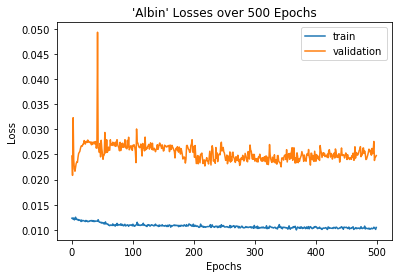

Average Training Score: 0.010729868590448518
Average Validation Score: 0.025330269515514373


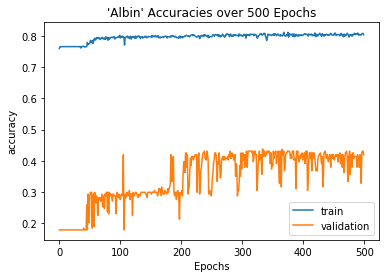

Average Training Score: 0.7971051437216339
Average Validation Score: 0.34583908045977013

validating on book: 'Ascham'
Epoch 0/499
----------



Phase:train
Confusion matrix:
 [[ 172  569]
 [  47 1934]]
loss 30.802375704050064



Phase:val
Confusion matrix:
 [[19  1]
 [ 2 74]]
loss 0.49662044644355774
Epoch 1/499
----------



Phase:train
Confusion matrix:
 [[ 185  556]
 [  47 1934]]
loss 30.701195865869522



Phase:val
Confusion matrix:
 [[19  1]
 [ 2 74]]
loss 0.5241175293922424
Epoch 2/499
----------



Phase:train
Confusion matrix:
 [[ 182  559]
 [  50 1931]]
loss 30.57775992155075



Phase:val
Confusion matrix:
 [[19  1]
 [ 2 74]]
loss 0.5127765536308289
Epoch 3/499
----------



Phase:train
Confusion matrix:
 [[ 180  561]
 [  48 1933]]
loss 30.484655126929283



Phase:val
Confusion matrix:
 [[19  1]
 [ 2 74]]
loss 0.5239116847515106
Epoch 4/499
----------


RuntimeError: cuda runtime error (2) : out of memory at /pytorch/aten/src/THC/generic/THCStorage.cu:58

In [11]:
# ========================================
# Step 5. execute the train process
# ========================================

# overriding to use CPU when GPU is busy
use_gpu = True
print('use_gpu is ' + str(use_gpu))

# get the model
# model = create_model_architecture()
model = create_model_architecture('jq_net1')

# train parameters
# num_training_epochs = 5
num_training_epochs = 500

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
earlyStoppingCriteria = EarlyStopping(min_delta = 1e-4, patience=5)

# dataloader parameters
cross_val_loaders = {}

all_loss = {'train': {}, 'val': {}}
all_accs = {'train': {}, 'val': {}}
# leave-one-book-out cross validation
for val_book in books_in_data:
    raw_loss = {'train': [], 'val' : []}
    raw_accs = {'train': [], 'val' : []}
    
    print("validating on book: '" + str(val_book) + "'")
    
    # define the train and validation loaders
    train_books = books_in_data - set([val_book])    
    cross_val_loaders["train"] = {b : book_data_loaders[b]["train"] for b in train_books}
    cross_val_loaders["val"] = {b : book_data_loaders[b]["val"] for b in [val_book]}
    
    # train
    trained_model = train(model,
                          criterion,
                          optimizer,
                          cross_val_loaders,
                          num_epochs=num_training_epochs)
    
    # update all loss dicts
    for p in raw_loss:
        all_loss[p][str(val_book)] = raw_loss[p]
    for p in raw_accs:
        all_accs[p][str(val_book)] = raw_accs[p]
    
    
    plot_losses(raw_loss['train'], raw_loss['val'],
                "'" + str(val_book) + "' Losses over " + str(num_training_epochs) +  " Epochs")
    plot_losses(raw_accs['train'], raw_accs['val'],
                "'" + str(val_book) + "' Accuracies over " + str(num_training_epochs) +  " Epochs",
               xlabel='accuracy')
    
    print()
    
    # remove the break as needed
#     break


print("training complete")

In [ ]:
# compute and plot total loss
# total_train_loss = [sum([all_train_loss[b][i] for b in all_train_loss]) for i in range(num_training_epochs)]
# total_val_loss = [sum([all_val_loss[b][i] for b in all_val_loss]) for i in range(num_training_epochs)]
# plot_losses(total_train_loss, total_val_loss, "Total losses over " + str(num_training_epochs) + " epochs")

total_loss = {p : [sum([all_loss[p][b][i] for b in all_loss[p]]) for i in range(num_training_epochs)]
             for p in all_loss}
total_accs = {p : [sum([all_accs[p][b][i] for b in all_accs[p]]) for i in range(num_training_epochs)]
             for p in all_accs}

plot_losses(total_loss['train'], total_loss['val'], "Total losses over " + str(num_training_epochs) + " epochs",
           xlabel = 'loss')
plot_losses(total_accs['train'], total_accs['val'], "Total accuracies over " + str(num_training_epochs) + " epochs",
           xlabel = 'accuracy')